# introduction

I plan to predict the prices of new cars entering the road, using data obtained from data.gov.il.  


# 1. Prepare setting

## 1.1. Libraries import

In [37]:
#!pip install deep-translator

In [38]:
#!pip install xgboost

In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import math
import scipy
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import ScalarFormatter
from xgboost import XGBRegressor
from xgboost import plot_importance

## 1.2 setting

In [40]:
pd.options.display.float_format = '{:.2f}'.format

## 1.3. Download and load data

In [41]:
url = "https://data.gov.il/api/3/action/datastore_search?resource_id=39f455bf-6db0-4926-859d-017f34eacbcb&limit=100000"
resp = requests.get(url)
resp.raise_for_status()

data = resp.json()
cars_prices = pd.DataFrame(data["result"]["records"])
cars_prices.head()

,_id,semel_yevuan,shem_yevuan,sug_degem,tozeret_cd,tozeret_nm,degem_cd,degem_nm,shnat_yitzur,mehir,kinuy_mishari
0,1,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,1000,C0635P R TWINGO EP,1996,54950,טווינגו 2.1 YSAE
1,2,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4060,L53A05 R19 RN 1.4I,1996,61990,91 NR I4.1 4 דלתות
2,3,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4061,L53A01 R19 RN.A1.4,1996,67450,91 אוטו AD.NR I4.1 4
3,4,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4070,L53A05 R19 RT 1.4I,1996,67450,91 3TR I4.1 4 דלתות
4,5,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4071,L53A01 R19 RT.A1.4,1996,70950,91 אוט' AD.TR I4.1 4


# 2. Prepare data

In [42]:
cars_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92217 entries, 0 to 92216
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   _id            92217 non-null  int64 
 1   semel_yevuan   92217 non-null  int64 
 2   shem_yevuan    92217 non-null  object
 3   sug_degem      92217 non-null  object
 4   tozeret_cd     92217 non-null  int64 
 5   tozeret_nm     92217 non-null  object
 6   degem_cd       92217 non-null  int64 
 7   degem_nm       92217 non-null  object
 8   shnat_yitzur   92217 non-null  int64 
 9   mehir          92217 non-null  int64 
 10  kinuy_mishari  92217 non-null  object
dtypes: int64(6), object(5)
memory usage: 7.7+ MB


In [43]:
cars_prices.describe()

,_id,semel_yevuan,tozeret_cd,degem_cd,shnat_yitzur,mehir
count,92217.00,92217.00,92217.00,92217.00,92217.00,92217.00
mean,46109.00,228.75,594.52,649.17,2015.64,338080.89
std,26620.90,245.88,320.06,965.33,7.48,295638.55
min,1.00,1.00,8.00,1.00,1996.00,34950.00
25%,23055.00,108.00,388.00,71.00,2011.00,151515.00
50%,46109.00,128.00,647.00,254.00,2017.00,249990.00
75%,69163.00,196.00,778.00,795.00,2022.00,412500.00
max,92217.00,1221.00,13811.00,9012.00,2025.00,6600001.00


In [44]:
cars_prices

,_id,semel_yevuan,shem_yevuan,sug_degem,tozeret_cd,tozeret_nm,degem_cd,degem_nm,shnat_yitzur,mehir,kinuy_mishari
0,1,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,1000,C0635P R TWINGO EP,1996,54950,טווינגו 2.1 YSAE
1,2,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4060,L53A05 R19 RN 1.4I,1996,61990,91 NR I4.1 4 דלתות
2,3,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4061,L53A01 R19 RN.A1.4,1996,67450,91 אוטו AD.NR I4.1 4
3,4,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4070,L53A05 R19 RT 1.4I,1996,67450,91 3TR I4.1 4 דלתות
4,5,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4071,L53A01 R19 RT.A1.4,1996,70950,91 אוט' AD.TR I4.1 4
...,...,...,...,...,...,...,...,...,...,...,...
92212,92213,1220,"ענווה מוטורס בע""מ",P,239,"ג'יפ ארה""ב",497,JXSJ,2025,580000,WRANGLER
92213,92214,1220,"ענווה מוטורס בע""מ",P,413,טויוטה יפן,628,TJH250L GNZAZA,2025,500000,LAND CRUISER
92214,92215,1220,"ענווה מוטורס בע""מ",P,488,"טויוטה ארה""ב",665,AXLH40L PPXEHA,2025,360000,SIENNA
92215,92216,1221,"א.א.מ עמנואל השקעות בע""מ",P,413,טויוטה יפן,629,AXAL52L ANXMBW,2025,170000,RAV4


## 2.1 Translate Rows

Translate the columns with Google Translate

Translate the column shem_yevuan

In [45]:
#from deep_translator import GoogleTranslator

# יוצרים עמודה חדשה עם התרגום
#unique_values = cars_prices['shem_yevuan'].dropna().unique()
#translation_dict = {
#    val: GoogleTranslator(source='auto', target='en').translate(val) for val in unique_values
#}
#cars_prices['shem_yevuan_en'] = cars_prices['shem_yevuan'].map(translation_dict)


To save time, I saved the translation results in the following table.

In [46]:
translation_dict={'קרסו מוטורס בע"מ': 'Carasso Motors Ltd.',
 'דוד לובינסקי': 'David Lubinsky',
 'חברת המזרח': 'Eastern Company',
 'טל - קאר': 'Tal - Car',
 'יפנאוטו': 'Japanuto',
 'חברה ישראלית לאוטומובילים': 'An Israeli company for autoomobiles',
 'מאיר - חברה למכוניות ומשאיות': 'Meir - Company for cars and trucks',
 'יוניברסל מוטורס ישראל': 'Universal Motors Israel',
 "צ'מפיון מוטורס ישראל": 'Champion Motors Israel',
 'מכשירי תנועה': 'Traffic devices',
 'קמור': 'convex',
 'סמלת מוטורס בע"מ': 'Motors Symbol Ltd.',
 'כלמוטור': 'From any',
 'יוניון מוטורס': 'Union Motors',
 'סקו - קאר': 'Sco - Car',
 'דלק מוטורס': 'Motors fuel',
 'כלמוביל': 'As a leader',
 'פסיפיק': 'Pacific',
 'כלמוביל מילר': 'Calmobil Miller',
 'פארמונט מוטורס': 'Pharmont Motors',
 'דוד לובינסקי בע"מ': 'David Lubinsky Ltd.',
 'יפנאוטו חברה ישראלית לרכב בע"מ': 'Japanoto Israeli Company Ltd.',
 'מאיר חברה למכוניות ומשאיות בע"': 'Meir Cars and Truck Company "',
 'יוניברסל מוטורס ישראל בע"מ': 'Universal Motors Israel Ltd.',
 'קאר איסט יבוא רכב בע"מ': 'Car Esther Import Vehicle Ltd.',
 'צ\'מפיון מוטורס בע"מ': 'Champion Motors Ltd.',
 'מכשירי תנועה ומכוניות 4002 בעמ': 'Traffic devices and cars 4002 in People',
 'אבניר חברה לרכב בע"מ': 'Avnier Company Car Ltd.',
 'מטרו מוטור שווק )1891( בע"מ': 'Metro Motor Shuk) 1891 (Ltd.',
 'כלמוביל מיצובישי': 'Calmobil Mitsubishi',
 'יוניון מוטורס בע"מ': 'Union Motors Ltd.',
 'דלק מוטורס בע"מ': 'Delek Motors Ltd.',
 'צ\'יינה מוטורס בע"מ': 'China Motors Ltd.',
 'קבוצת עמק איילון ס.כ. בע"מ': 'Ayalon Valley Group SP Ltd.',
 'כלמוביל יונדאי': 'As a Hyundai leader',
 'אלבר צי רכב )ר.צ( בע"מ': 'Alber Vehicle Fleet) R.T. (Ltd.',
 'מכשירי תנועה ומשאיות': 'Traffic devices and trucks',
 'כלמוביל מרצדס': 'As a Mercedes',
 'ק.מ.י - קוריאה מוטורס ישראל בע': 'KMI - Korea Motors Israel',
 'אוטוארט )איי.אל.( בע"מ': 'Autoart) AL (Ltd.',
 "צ'מפיון  קאר ש.מ": 'Champion Carr S.M.',
 'אוטו איטליה איי אל בע"מ': 'Otto Italy Island Ltd.',
 'פלדטראק': 'Feldtrack',
 'מפרם סוכנויות )9991( בע"מ': 'Divorce agencies) 9991 (Ltd.',
 'ש.י.ר. - שלמה יבוא רכב בע"מ': 'song. - Shlomo will come by car Ltd.',
 'אוטו חן בע"מ': 'Otto Chen Ltd.',
 'בטר פלייס מוטורס בע"מ': 'Better Place Motors Ltd.',
 'יוניברסל משאיות ישראל בע"מ': 'Universal Israel Ltd.',
 'אלון מוסכי רכב )2991( בע"מ': 'Alon Car Garages) 2991 (Ltd.',
 'המאגר ב.נ.כ. בע"מ': 'BN Database Ltd.',
 "גלובל אוטו מקס בע''מ": 'Global Otto Max Ltd.',
 'לאופק - תיירות טבע בע"מ': 'To Horizon - Nature Tourism Ltd.',
 'אורכיד ספורטס קארס בע"מ': 'Orchid Sports Cars Ltd.',
 'אוטופוינט בע"מ': 'Utophome Ltd.',
 'כ.פ עומר קאר בע"מ': 'KP Omer Car Ltd.',
 'גז פרו בע"מ': 'Pro -gas Ltd.',
 'בוואריאן מוטורס קלאב בע"מ': 'Bavarian Motors Club Ltd.',
 'ליסינג מימוני ליעד בע"מ': 'Financing Leasing to Destination Ltd.',
 'אדר סאם מוטורס בע"מ': 'Adar Sam Motors Ltd.',
 'ג.ש.ר. גולן שיווק רכב )5002(': 'bridge. Golan Car Marketing) 5002 (',
 'קומפוננט ח. )1991( בע"מ': 'Component H. ) 1991 (Ltd.',
 'שלומי שבו': 'Shlomi where',
 'אמיליה קארס בע"מ': 'Emilia Cars Ltd.',
 'שקד רכבי יוקרה בע"מ': 'Shaked Luxury Vehicles Ltd.',
 'א.א. יבוא ושיווק בע"מ': 'AA Import and Marketing Ltd.',
 'ריעאני הדר הילוך ראשון': "Ra'anani Hadar first gear",
 'פנקייר בע"מ': 'Pankir Ltd.',
 'מויאל מתי - אאוטלט חשמל': 'Moyal When - Electric Outlet',
 'עובייד זועבי טארק - זועבי טארק': 'Obeid Zoabi Tark - Zoabi Tark',
 'רפי ורפאל מוסכים בע"מ': 'Rafi and Rafael Garages Ltd.',
 'שלמה מוטורס בע"מ': 'Shlomo Motors Ltd.',
 'אוריקאר תחבורה בע"מ': 'Orikar Transport Ltd.',
 'מרצי טל': 'Running Tal',
 'ניקסט השכרת רכב בע"מ': 'Next Car Rental Ltd.',
 'ס.ה ניהול טוב בע"מ': 'SH good management Ltd.',
 'אוטו המוביל פ.מ. 8002 בע"מ': 'Auto leading PM 8002 Ltd.',
 'ש. גרנות הולדינגס בע"מ': 'that. Granot Holdings Ltd.',
 'א.צ.מ איבזור ציוד מכוניות בע"מ': 'ASM Care Equipment Increase Ltd.',
 'י. אלסומאו בע"מ': 'J. Alsomo Ltd.',
 'אסרף שרותי רכב 0002 בע"מ': 'Asraf Car Services 0002 Ltd.',
 'קורן קובי': 'Koren Kobe',
 'חכם יעקב בועז - ח.י השקעות': 'Smart Jacob Boaz - HI Investments',
 'גיא מאור בע"מ': 'Guy Maor Ltd.',
 'סאלח מוטורס בע"מ': 'Saleh Motors Ltd.',
 'יונה רחמים': 'Jonah Mercy',
 'מ.ז דיזל מימון וסחר בע"מ': 'MZ Diesel Financing and Trade Ltd.',
 'ש.מ.ש. אחזקות ויזמות בע"מ': 'sun. Holdings and Entrepreneurship Ltd.',
 'חליוה יעקב': 'Halihua Jacob',
 'פסו יניב': 'Psu Yaniv',
 'ידידיה ובניו בע"מ': 'Its friends and sons Ltd.',
 'הקניה הבטוחה )0002( בע"מ': 'Safe Buy) 0002 (Ltd.',
 'זמן איכות פלוס בע"מ': 'Quality Plus Ltd.',
 'חכימיאן אשר - רכב תלפיות': 'Hochimian which - Talpiot vehicle',
 'ידידיה תעשיות ונכסים בע"מ': 'Friends of Industries and Properties Ltd.',
 'א.א. איסוף ומיחזור בע"מ': 'AA Collect and Recycling Ltd.',
 'אסיה תורס )8002( בע"מ': 'Asia Thorks) 8002 (Ltd.',
 'טרגט מוטורס מ.ר 6102 בע"מ': 'Target Motors MR 6102 Ltd.',
 'כהן גבריאל': 'Cohen Gabriel',
 'סגל אליעזר': 'Eliezer roster',
 'אילן בן דוד': 'Ilan Ben David',
 'א.נ.ר.נ. חברה למסחר בע"מ': 'ENN Company in Ltd.',
 'לגזייל אבישי נסים-תיווך ומסחר': 'Gazyi Avishai Nissim-Revival and Trade',
 'פוזיצקי איתי': 'Positsky with me',
 'אקספיד מוטורס בע"מ': 'Exfide Motors Ltd.',
 'יעקובוב ארז': 'Jacobov Erez',
 'ידידיה סחר בע"מ': 'Friends Trade Ltd.',
 'בן ציון גבאי': 'Ben Zion Gabay',
 'מסיעי שדרות-כהן ובניו בע"מ': 'Tahavi-Cohen and News Trains Ltd.',
 'שי זגה': 'Shay Zagga',
 'א.מ.מ.שיווק רכבי יוקרה וליסינג': 'AMMMS Luxury Vehicle Marketing',
 'סאליקאר ג\'אפאקום בע"מ': 'Salicar Japacom Ltd.',
 'רונן שררה': 'Ronen has been prevailed',
 'רוני מוטורס סוכנות רכב בע"מ': 'Ronnie Motors Car Agency Ltd.',
 'סבח מוצרי תעבורה': 'Transport Product Sabah',
 'דוד ויונתן מוטורס בע"מ': 'David and Jonathan Motors Ltd.',
 'יצחק בובו': 'Isaac Bobo',
 'מאי מוטורס )5102( בע"מ': 'May Motors) 5102 (Ltd.',
 'יארין בס': 'Yarin Bass',
 'דוד זוארס': 'David Zuars',
 'אלף אקספרס בע"מ': 'Thousand Express Ltd.',
 'יעקב קוסיאשוילי': 'Jacob Kosyashvili',
 'נחום דוד': 'Nahum David',
 'נ.ט. דרים קארס ייעוץ בע"מ': 'N. Dream Cars Consulting Ltd.',
 'ספיישל קארס  בע"מ': 'Special Cars Ltd.',
 'מי לימוזין בע"מ': 'Limosine Ltd.',
 'דביר רמי': 'Dvir Remy',
 'נחום פנחס': 'Nahum Pinchas',
 'כלמוביל טרייד-אין בע"מ': 'Calmobil Trade-In Ltd.',
 'אמל זגייר בע"מ': 'Amal Zagir Ltd.',
 'חיים דדשוב': 'Haim Ddith',
 'ג. אביטל סחר בע"מ': 'third. Avital Trade Ltd.',
 'גור בן רוחי מירב - קלאסיק קאר': 'Gore Ben Rubi Meirav - Classic Car',
 'אם הרכב - סוכנות רכב בע"מ': 'If the vehicle - car dealership Ltd.',
 'זייתון ויקי - אופיר סוכנויות': 'Vicky Zeimon - Ophir Agencies',
 'שיא סוכנויות רכב שחודה 0002': 'The peak of car dealerships that are 0002',
 'בטר קאר בע"מ': 'Better Car Ltd.',
 'לוקסנדר סחר בע"מ': 'Luxander Trade Ltd.',
 'אוסדון מיכה - רימונים': 'Osadon Micah - pomegranates',
 'סנטר קאר שרותי ליסינג ומימון': 'Center Car Laser and Financing Services',
 'ליחי חלווה': 'Looks Habiav',
 'בלו סקאי 0002 השכרת רכב בע"מ': 'Blue Sky 0002 Car rental Ltd.',
 'שלומי קריאף': 'Shlomi Cref',
 'קרופולד שמעון ברנרד': 'Crupold Shimon Bernard',
 'יצחק אלבז': 'Isaac Elbaz',
 'אוטו חן בע"מ )יבואן זעיר(': 'Otto Chen Ltd.) a tiny importer (',
 'נ.ק. שחר השקעות )7002( בע"מ': 'NC Dawn Investments) 7002 (Ltd.',
 'בלאק פוקס ישראל בע"מ': 'Black Fox Israel Ltd.',
 'מיכאל אנוקוב': 'Michael Anokov',
 'שחר סיני': 'Sinai dawn',
 'מאיר בן צור': 'Meir Ben Tzur',
 'יוסף נחאיסי': 'Joseph Nahaisi',
 'חן מרצי': 'Chen Razim',
 'ג.ש.ר גולן השכרת רכב )9002(': 'GSR Golan Car Rent) 9002 (',
 'אריאל משה': 'Ariel Moshe',
 'וי 21 רכבי יוקרה בע"מ': 'VI 21 Luxury Vehicles Ltd.',
 'תמן תעשיית מערכות נהיגה בע"מ': 'Taman Driving Systems Inc.',
 'יוסף בכר': 'Joseph Bachar',
 'שותפות עמי ארבי את רועי יצחק': 'Partnership with my people Arbi',
 'אחמד שהואן': 'Ahmed he',
 'ארביב שלום סוכנויות בע"מ': 'Arbib Shalom Ltd.',
 'שקד יואל': 'Shaked Joel',
 'מוסך דיזל טבריה בע"מ': 'Diesel Tiberias Garage Ltd.',
 'יו.אס.א. מוטורס בע"מ': 'ASA Motors Ltd.',
 'נחמן גבאי': 'Nachman Gabay',
 '"המכונית" שאול את יצחק בע"מ': '"Car" Saul Isaac Ltd.',
 'אלינוי השקעות בע"מ': 'Alino Investments Ltd.',
 'אבו יונס מוהנד': 'Abu Yunis Mohand',
 'סטאר מוטור בע"מ': 'Star Motor Ltd.',
 'א.ר.י ביצוע 555 בע"מ': 'ARI Execution 555 Ltd.',
 'גיל יחיאל': 'Gil Yechiel',
 'מרצי יצחק אייל': 'March Yitzhak Eyal',
 'חן מוטורס בע"מ': 'Chen Motors Ltd.',
 'זידאן אחמד - גולאן מוטורס': 'Zidane Ahmed - Golan Motors',
 'מיליון מכוניות בע"מ': 'Million cars Ltd.',
 'אוטו שי ראשל"צ בע"מ': 'Otto Shai Rashz Ltd.',
 'חלפון יעקוב': 'Halfon Jacob',
 'בלו סקאי ליסינג תפעולי בע"מ': 'Blue Skai Operations Ltd. Ltd.',
 'עזריה גיא - טקסי דיל': 'Azaria Guy - Deal ceremonies',
 'כלמוביל בע"מ': 'Calmobil Ltd.',
 'אלכסנדר חאיט': 'Alexander Hitt',
 'יעד ליסינג ומימון לרכב בע"מ': 'Destination of leasing and car funding Ltd.',
 'ברמן אוטו גרופ בע"מ': 'Berman Otto Group Ltd.',
 'ג.ש.ר גולן שירותי רכב בע"מ': 'GSR Golan Car Services Ltd.',
 'ישראל צ\'יינה א.וי. מוטורס בע"מ': 'Israel China A. Motors Ltd.',
 "עבד אלרחמאן מחאג'נה": 'Abdel Allaman of Hajjana',
 'נסים כהן': 'Nissim Cohen',
 'סימון בן-משה': 'Simon Ben-Moshe',
 'אנוקוב גרופ בע"מ': 'Anokov Group Ltd.',
 'מרדכי פרץ - רום מוטורס': 'Mordechai Peretz - Rum Motors',
 'קי-דאן ניהול והשקעות בע"מ': 'Key-Dan Management and Investment Ltd.',
 'א.ג. גרינס נכסים והשקעות בע"מ': 'AG Great Properties and Investments Ltd.',
 'עלית מוטורס ישראל בע"מ': 'Elite Motors Israel Ltd.',
 'סטאר שירותי רכב בע"מ': 'Star Car Services Ltd.',
 'מור רפאל רפי': 'Moore Raphael Rafi',
 'בס אלירן פרץ': 'Bass Eliran Peretz',
 'ארז אמויאל - גרייס מוטורס': 'Erez Amoyal - Grace Motors',
 'סאנטק ציפויים בע"מ': 'Santak coatings Ltd.',
 "סבח ג'ק ליאור": 'Jack Lior Sabah',
 "טאוב ג'קי יעקב": 'Taub Jackie Jacob',
 'אוריון מוביליטי בע"מ': 'Orion Leady Ltd.',
 'עמוס אבטליון': 'Amos Amplion',
 'יורודרייב ניהול ציי רכב בע"מ': 'Eurodreyev Management Vehicle Ltd.',
 'מונארט נכסים בע"מ': 'Monart Properties Ltd.',
 'זיתונה דרייב בע"מ': 'Zeitone Drive Ltd.',
 'יפה בן צור': 'Beautiful Ben Tzur',
 'גל לירן': 'Gal Liran',
 'ארטליס מוטורס בע"מ': 'Artlis Motors Ltd.',
 'איל חכים': 'A ram of holes',
 'בעז אלון סוכנויות רכב בע"מ': 'Boaz Alon Car Agencies Ltd.',
 'ג.ש.ר.גולן שרותי רכב בע"מ': 'GSHRlan Car Services Ltd.',
 'דלהום זגגות ושירותי רכב בע"מ': 'Delhum glazed and car services Ltd.',
 'אושרי פרץ סחר והשקעות בע"מ': 'Oshri Peretz Trade and Investment Ltd.',
 'א.ל. מימושים בע"מ': 'to. Realizations Ltd.',
 'אלון מאיר': 'Alon Meir',
 'אבי בן שבת': 'My father Shabbat',
 'טל טויטו': 'Tal Toyo',
 'גלית זגה': 'Galit Zega',
 'אברהם סימן טוב': 'Abraham a good sign',
 'איי.טי.אם שרותי אחסנה לוגיסטקה': 'ITM storage service Logista',
 'סגייר ולאא - RAC ERAM': 'Sagir and La - RAC ERAM',
 'תומר מועלם -רויאלטי ייעוץ וסחר': 'Tomer Moalem -Revaltic Counseling and Trade',
 'יראן סחר והשקעות בע"מ': 'Jeran Trade and Investment Ltd.',
 'טסלה מוטורס ישראל בע"מ': 'Tesla Motors Israel Ltd.',
 'זעאתרה אקספרס בע"מ': "Za'atra Express Ltd.",
 'אסדי בלאל': 'Assadi Belal',
 'שמואל פרל': 'Samuel Pearl',
 'ביג בן קאר בע"מ': 'Big Ben Kar Ltd.',
 'תום טוראל': 'Tom Torral',
 'נתנאל רחמני': 'Nathaniel Rahmani',
 'עמנואל בבייב': 'Emanuel Babev',
 'אלפא ליסינג נהיגה עצמית בע"מ': 'Alfa Lising Self -Driving Ltd.',
 'אליאס חדיד': 'Elias Hadid',
 'לוזון ליסינג בע"מ': 'Luzon Leasing Ltd.',
 'אוטו פלוס 0002 בע"מ': 'Otto Plus 0002 Ltd.',
 'הראשונים הסעות בע"מ': 'The first shuttles Ltd.',
 'ניסים-יעקב נידם': 'Nissim-Jacob Nam',
 'מוחמד קוואסמי': 'Muhammad Quasmi',
 'רזמה שיווק וסחר בע"מ': 'Razma Marketing and Trade Ltd.',
 'בלינק טורס בע"מ': 'Blink Tours Ltd.',
 'לוי\'ס קארס בע"מ': 'Levi Cars Ltd.',
 'דודו פינס השקעות בע"מ': 'Dudu Pines Investments Ltd.',
 'יצחק אוחנה': 'Isaac Ohana',
 'א. רוטמן השקעות בע"מ': 'A. Rotman Investments Ltd.',
 'פריד פאעור': 'Fried Posted',
 'י.ח.ד מוטורס יבואני רכב בע"מ': 'YM Motors Motors Car Importers Ltd.',
 'מרכז שרות משה דיין בע"מ': 'Moshe Dayan Service Center Ltd.',
 'אשכנזי שלמה': 'Ashkenazi Shlomo',
 'ו.אס.פי יבוא ושיווק עולמי בע"מ': 'VAP World Import and Marketing Ltd.',
 'דהן אור פז': 'Dahan Or Paz',
 'יו.די.אס אינטרנשיונל בע"מ': 'YDS International Ltd.',
 'יוסף מלך': 'Joseph King',
 'שמעון שמש': 'Shimon Sun',
 'אמין קאר בע"מ': 'Amin Carr Ltd.',
 'אמארה בילאל': 'Amara Bilal',
 'ראני רוחאנא': 'Ranni Ruhana',
 'ז.כ איילון פרוייקטים בעץ בע"מ': 'Z. Ayalon Tree Projects Ltd.',
 'קארמקס סוכנויות רכב בע"מ': 'Carmex Car Agencies Ltd.',
 'סופר ג\'יפ י.ר.א בע"מ': 'Super Jeep YRA Ltd.',
 'עמית צור סוכנויות רכב בע"מ': 'Amit Tzur Car Agencies Ltd.',
 'ב.ה. אופיר ליסינג בע"מ': 'B. Ophir Leasing Ltd.',
 'קאר-אל שיווק בע"מ': 'Car-El Marketing Ltd.',
 'גלקסי מוצרי צריכה בע"מ': 'Galaxy Consumer Products Ltd.',
 'פרידלנדר סחר רכב בע"מ': 'Friedlander Car Trade Ltd.',
 'טרייד אין אי אר תחבורה בע"מ': 'Trade does not have an island in Ltd.',
 'למונס איי.אל בע"מ': 'Monsi AL Ltd.',
 'די.אס.אס קלאס רכבים בע"מ': 'DS Class Vehicles Ltd.',
 'אוטו פרימיום סי.אר.אס בע"מ': 'Otto Premium CCS Ltd.',
 'אוטו-קאר ליסינג )5002( בע"מ': 'Otto-Car Leasing) 5002 (Ltd.',
 'יארין ג ב אחזקות בע"מ': 'Yarin C. Holdings Ltd.',
 'יוסף לזה': 'Joseph to that',
 'שג-אל עוצמה תשתיות עפר ופיתוח': 'SHE-Power Enthusiasm and Development',
 'פאי מוטורס בע"מ': 'Pie Motors Ltd.',
 'אילן יחזקאל': 'Ilan Ezekiel',
 'ניר ברנשטיין': 'Nir Bernstein',
 'קובי בוטראי': 'Kobe Botara',
 'ישרא-לנהריה בע"מ': 'Isra-Lenaria Ltd.',
 "ג'יריס ג'יריס - רכב אלחביב": 'Jiris Jiris - Al -Habib Vehicle',
 'אלי פורטל': 'Eli Portal',
 'הראל כהן': 'Harel Cohen',
 'עידן חליבה': 'A milking era',
 'הינומה מ.א.י בע"מ': 'Hinoma MAI Ltd.',
 'אביב זייתון': 'Spring Zeiton',
 'גד אלקריף': 'Gad Alkrif',
 'צבי מנשה': 'Deer Menashe',
 'נ.ת. אלפא מוטורס בע"מ': 'N. Alfa Motors Ltd.',
 'שמעון שמש סוכנויות בע"מ': 'Shimon Shemesh Ltd.',
 'גולדין קזה בע"מ': 'Goldin Kaza Ltd.',
 'גלובל אוטו מקס בע"מ': 'Global Otto Max Ltd.',
 'וואן )1( ליס בע"מ': 'Wan) 1 (Lis Ltd.',
 'בלו סקאי סוכנות לביטוח בע"מ': 'Blue Sky Insurance Agency Ltd.',
 'תומר אייל': 'Tomer Eyal',
 'אלברט שטרנשטיין': 'Albert Stranstein',
 'גולאן מוטורס בע"מ': 'Golan Motors Ltd.',
 'י.ח.ד. מוטורס יבואני רכב בע"מ': 'together. Motors Car Importers Ltd.',
 'שואוקארס ר.ע. שיווק ויעוץ בע"מ': 'Shuocars R. Marketing and Counseling Ltd.',
 'אלבר י.מ.ת. להפצת כלי רכב בע"מ': 'Alber YM To distribute vehicles to Ltd.',
 'יהודה לביאב': 'Yehuda Laviav',
 'גרי.8.אוטו שיפינג בע"מ': 'Gary',
 'רונן ירון': 'Ronen Yaron',
 "מוראד אבו נאג'י": 'Murad Abu Naji',
 "עבדללה חאג'": 'Abdellah Hajj',
 'נסיאל דגבר': 'Nesliel is an limb',
 'ארסן פולטוב': 'Arsenn Polletov',
 'שאול עסקי רכב בע"מ': 'Saul Car Business Ltd.',
 'משכיל השקעות ויזום פרוקטים בעמ': 'Educated Investments and Prompts in Pop',
 'רמי לוי': 'Remy Levy',
 'סנטרל פלוס בע"מ': 'Central Plus Ltd.',
 'ר.ש. פרימיום לקשרי מוטורס בע"מ': 'Rash Premium for Motors Ltd.',
 'שמוליק מוניות בע"מ': 'Shmulik Taxi Ltd.',
 'אורטקס רכיבים בע"מ': 'Ortex Components Ltd.',
 'אם.די. מוטורס בע"מ': 'MD Motors Ltd.',
 'יצחק אדרי': 'Isaac Edri',
 'קאריסטוקראט אוטומובייל בע"מ': 'Caristocrat Automobile Inc.',
 'אליהו לוי': 'Elijah Levy',
 'ביי אנד דרייב שירותי מימון בעמ': 'Bye and Drive Robev Finance Services',
 'אי.וי אלקטריק מוטורס בע"מ': 'IV Electric Motors Ltd.',
 'נוף הגליל רכבי יוקרה בע"מ': 'Luxury Galilee Landscape Ltd.',
 'סופר ג\'יפ ישראל י.ר.א בע"מ': 'Super Jeep Israel YR',
 'חתאם נעאמנה': "Hammus Na'amama",
 'אלון שירותי רכב - טובי בע"מ': 'Alon Car Services - Toby Ltd.',
 'רמי קאר מוטורס בע"מ': 'Rami Car Motors Ltd.',
 'בלאל מריסאת': 'Ballal Marisat',
 'פהד עבד אל קאדר': 'Mobile Abd al -Qader',
 'אילון מיכאל אחזקות )2102( בע"מ': 'Elon Michael Holdings) 2102 (Ltd.',
 'וליד השכרת רכב בע"מ': 'Well Car Rental Ltd.',
 'מהנד קוואסמי': 'Quasmic Engineer',
 'קליל פרמיום בע"מ': 'Light Premium Ltd.',
 'צ\'יטה רכבי יוקרה בע"מ': 'Chaita luxury vehicles Ltd.',
 'א.ר.ר. יורו קאר בע"מ': 'ARR Euro Car Ltd.',
 'א.א. קאר סנטר מוטורס בע"מ': 'AA Carr Center Motors Ltd.',
 'משה טיסונה': 'Moshe Tisuna',
 'ליאור ויסמן': 'Lior Wiseman',
 'אביב זגה': 'Spring Zagga',
 'מוחמד נעמה )4991( בע"מ': 'Muhammad Naama) 4991 (Ltd.',
 'שרון סולומון': 'Sharon Solomon',
 'ידין חי לוי': 'Yadin Hai Levy',
 'ליאור ארמונד כהן': 'Lior Armand Cohen',
 'גיתית גרידיש': 'Gititish Gradish',
 'גולן מירום': 'Golan More',
 'חיים אוריון': 'Haim Orion',
 'אוטו פרימיום עומר מיאל': 'Otto Premium Omar',
 'א.ט.ש. אמיר טל שחר בע"מ': 'A. Amir Tal Dawn Ltd.',
 'בן שריון': 'Ben Armor',
 'ר.מ.א. המומחים לחשמל בע"מ': 'RM Electricity experts Ltd.',
 'שמעון ביטון': 'Shimon Biton',
 'ר.פ.ז השקעות ונכסים 0202 בע"מ': 'RPA Investments and Properties 0202 Ltd.',
 'איתמר לניאדו': 'Itamar Laniado',
 'יצחק בנס': 'Isaac Bans',
 'גיאו מוביליטי בע"מ': 'Goo Mobilitt Ltd.',
 'שייאל מוטורס בע"מ': 'Sheld Motors Ltd.',
 'יוחאי מנחם': 'Yochai Menachem',
 'אפ 1 פתרונות פיננסים בע"מ': 'Up 1 Finance Solutions Ltd.',
 'ציון שמואל דואק': 'Zion Shmuel Duak',
 'כ.ל. רכב ומימון בע"מ': 'all. Vehicle and Finance Ltd.',
 'דוד אמשי סוכנויות בע"מ': 'David Last Agencies Ltd.',
 'א.ל.מ. ארגמן בע"מ': 'ALM Crimson Ltd.',
 'ל.ט. דרים קארס ייעוץ בע"מ': 'L.T. Dream Cars Consulting Ltd.',
 'עמרי פואז': 'Omri Fuz',
 'סוליקאר - השקעות רכב בע"מ': 'Solikar - Vehicle Investment Ltd.',
 'אדריס הובלות וחומרי בנין בע"מ': 'Edris Moving and Building Breens Ltd.',
 'אלמוג כחול אחזקות בע"מ': 'Blue Coral Holding Ltd.',
 'מיכאל ביטון': 'Michael Biton',
 'צמיגי יוסי זוארץ )4991( בע"מ': 'Yossi Zuarz tires) 4991 (Ltd.',
 "יעקב פראג'ס": 'Jacob Frages',
 'אוטוארט)אי.אל(בע"מ': 'Autoart) IA (Ltd.',
 'אל רואי לוי': 'To Roy Levy',
 'ר.ב.ס השקעות ונכסים בע"מ': 'RBS Investments and Properties Ltd.',
 'ירון פרי יזמות וסחר בע"מ': 'Yaron Perry Entrepreneurship and Trade Ltd.',
 'שירלי יונה גל': 'Shirley Yona Gal',
 'קבוצת שיווק 8402 בע"מ': 'Marketing Group 8402 Ltd.',
 'אמיר דגש': 'Amir emphasis',
 'חן זגה': 'Chen Zega',
 'אביב לוי': 'Spring Levy',
 'תמיר מסילתי': 'Tamir Massey',
 'ציון זוארס': 'Zion Zauras',
 'אטמור בע"מ': 'Atmore Ltd.',
 'י.מ. סוכנות ושיווק מוניות בע"מ': 'YM Agency and Taxi Marketing Ltd.',
 'אנרי קוגוניה': 'Henri Cugun',
 'איתי חנן וינריב': 'With me Hanan Vinariv',
 'עדי לוי': 'Adi Levy',
 'שרית דואק': 'Sarit Duak',
 "תייסיר חג'אזי": 'Taisir Hajazi',
 'טופליין מוטורס בע"מ': 'Toplain Motors Ltd.',
 'רואיל סוכנויות רכב בע"מ': 'Ruil Car Agencies Ltd.',
 'ליאור שי ברונשטיין': 'Lior Shai Bronstein',
 'מוריס מעדי': 'Morris Refill',
 'יוסף ירחמיאל ברוידא': 'Joseph Yalmmiel Broida',
 'טרייד מוביל בע"מ': 'Trade leading Ltd.',
 'משכנות רזיאל תל-אביב בע"מ': 'Raziel Tel Aviv Ltd.',
 'חיים חואטי בוקריס': 'Haim ovaries buckraiss',
 'צבי רוזנטל': 'Deer Rosenthal',
 'ג. אביטל יבוא בע"מ': 'third. Avital will come in Ltd.',
 'וי.דא.כ. מתכת בע"מ': 'VD Metal Ltd.',
 'יניב מרציאנו': 'Yaniv Marciano',
 'עמי דבוש מתן שרותי הובלה ומנוף': 'Ami Debush Moving Transport and Lever Services',
 'מילניום - דיל בע"מ': 'Millennium - Deal Ltd.',
 'תמיר - חברה להשכרת רכב בע"מ': 'Tamir - Car Rental Company Ltd.',
 'איי.אר.ג\'יי. מוטורס 4102 בע"מ': 'ARAJ. Motors 4102 Ltd.',
 'דינה בן סימון': 'Dina Ben Simon',
 'ארלין טהר בס': 'Arlen Tehr Bass',
 'מיטל פרץ': 'Meital Peretz',
 'מ.צ. בנימיני ייזום והשקעות בעמ': 'M. Binyamini Initiative and Investment in People',
 'גד חלבי': 'Gad milky',
 'בן מוטורס סחר והשקעות בע"מ': 'Ben Motors Trade and Investment Ltd.',
 'אס.ד.איי לוגיסטיקה בע"מ': 'SS Logistics Ltd.',
 'בן אור ת.א.מ. בע"מ': 'Ben Or TM Ltd.',
 'סי אנד קאר א.ש בע"מ': 'Si & Carr ESH Ltd.',
 'אור מזרחי': 'Eastern light',
 'ישראל אותמיזגין': 'Israel Ormizagin',
 'ציון ביני': 'Zion between me',
 'שימרית טורבתי': 'Scaly shimmer',
 'חיה דוידוב': 'Haya Davidov',
 'מוחמד גנומה': 'Muhammad Ganoma',
 'מיכאל חנוך סוכנויות רכב בע"מ': 'Michael Hanoch Ltd.',
 'א. ברזני הסעות בע"מ': 'A. Shuttle Brazans Ltd.',
 'רונן דוידוב': 'Ronen Davidov',
 'מוריס בוטון': 'Morris Botton',
 'סלומון דוד': 'Salomon David',
 'עלא כנעאן': "Ala Ka'aanan",
 'באסם רוחאנא': 'Bassem Ruhana',
 'אורי זיגדון': 'Uri Zigdon',
 'אביחי פינס סחר מכוניות בע"מ': 'Avihai Pines Trading Car Ltd.',
 'עופר נעים': 'Ofer pleasant',
 'ניצן סבח': 'Nitzan Sabah',
 'ירין ארד': 'Yarin Arad',
 'קינג קלאסה מוטורס בע"מ': 'King Classa Motors Ltd.',
 'אהרן סימן טוב': 'Aharon a good sign',
 'יבגני שטני': 'Yavdeni Stanish',
 'שלמה אוחיון': 'Shlomo Ohayon',
 'תייסיר קאר בע"מ': 'Taisir Car Ltd.',
 'תיור וסיור הגליל ה.ס בע"מ': 'Tour and Tour Galilee HaS Ltd.',
 'א.ר - אלויסאם פרויקטים בע"מ': 'AR - Elvisam Projects Ltd.',
 'אדואר ברהום בע"מ': 'Eduard Baraum Ltd.',
 'דוד דין ספיר': 'David Sapir',
 'אלעד מזרחי': 'Elad Mizrahi',
 'פ.א.י רכבים בע"מ': 'PAI vehicles Ltd.',
 'אוטו רומי בע"מ': 'Otto Roman Ltd.',
 'יצחק יום טוב': 'Isaac a good day',
 'שלמה אהרוני': 'Shlomo Aharoni',
 'שרון זולפין': 'Sharon Zolpain',
 'שי נאור': 'Shay enlightened',
 'טסט - רישוי': 'Test - licensing',
 'חזקייה אילן איסחקוב': 'Hezekiya Ilan Hashakov',
 'אדם מוטורס בע"מ': 'Adam Motors Ltd.',
 "נאהד מחאג'נה": 'Nahad Mahajna',
 'פנומנה קצ\'ורי מוטורס בע"מ': 'Phenomenon Kachori Motors Ltd.',
 'דן בכר': 'Dan Bachar',
 'שמואל סמי ענבי': 'Samuel Sami Gravi',
 'נאור שי השקעות בע"מ': 'Enlightenment Shai Investment Ltd.',
 'קבוצת חכם אן.אר.אן. בע"מ': 'The Smart Group Ltd.',
 'גרמן )גבריאל( כהן': 'German) Gabriel (Cohen',
 'קבוצת וקסמן 5102 בע"מ': 'Waxman Group 5102 Ltd.',
 'ששון חיים יצחק': 'Sasson Haim Yitzhak',
 'ר. איתמרס בע"מ': 'R. Itams Ltd.',
 'קיי.אמ מוטורס סי.טי.די בע"מ': 'KIM Motors CTS Ltd.',
 'א.א.מ עמנואל השקעות בע"מ': 'AA Emanuel Investment Ltd.',
 'בוריס מטוסובסקי': 'Boris Metosovsky',
 'אבנר מנוצהרי': 'Avner Menzari',
 'הלאל קאסם': 'Hallem Qasem',
 'דורון זיטון': 'Doron Ziton',
 'אורלי חליבה': 'Orly milking',
 'פלאי סמא לוגיסטיקס בע"מ': 'Wonders Sam Logistics Ltd.',
 'התחייה מוטורס בע"מ': 'Revival Motors Ltd.',
 'רענן זיגמן': 'Raanan Siggman',
 'סעיד עואודה': 'Said Awuda',
 'גבריאל כהן': 'Gabriel Cohen',
 'יוסף צדוק': 'Joseph Zadok',
 'ליס קום בע"מ': 'Lis Compa. Ltd.',
 'סאמי אלענאמי': 'Sami Alanai',
 'חיים אביחי חזיזה': 'Haim Avichai Hezat',
 'מאיר זיטון': 'Meir Ziton',
 'ניקסט סמייל בע"מ': 'Nies Smile Ltd.',
 'ליאור שריון': 'Lior Armor',
 'אלכסנדר אמסלם': 'Alexander Amsalem',
 'סלטי טוייס בע"מ': 'Toyase salads Ltd.',
 'ענווה מוטורס בע"מ': 'Humility Motors Ltd.',
 "פרג' כהן": 'Faraj Cohen',
 'אבי קריו שיווק בע"מ': 'My father Kerro Marketing Ltd.',
 'אילן בן דוד יבואן רכב בע"מ': 'Ilan Ben David Importer Ltd.',
 'קוסאשווילי מוטורס בע"מ': 'Kosashvili Motors Ltd.',
 'אור ירון': 'Light Yaron',
 'גוסטבו אורבך': 'Gustavo Urbach',
 'עמית כהן': 'Amit Cohen',
 'פאוזי אבו עאייש': 'Fawzi Abu Ishish',
 'אליהו חכימי': 'Elijah Hakimi',
 'האחים קבועה בע"מ': 'Brothers Fixed Ltd.',
 'זכוכית מרכז זגגות טרקטורים בעמ': 'Glass Center Territors in People',
 'שריף הזימה בע"מ': 'Shrif Summer Ltd.',
 'משה קריאם': 'Moshe Keriam',
 'שייפס עצוב ויצור רהיטים בע"מ': 'Sad Sad and Create Furniture Ltd.',
 'אודי שאלתיאל': 'Udi Shaltiel',
 'י.ש.ע. תכנון תנאים סוציאלים בע': 'salvation. Planning Social Conditions',
 'אלכסנדר דנה': 'Alexander Dana',
 'מתן בוכניק': 'Matan Buchnick',
 'קוראל ליאל לוי': 'Core Liel Levy',
 'גלגלי מרכבה בע"מ': 'Carriage Wheels Ltd.',
 'מ.ת מוטורס בע"מ': 'M. Motors Ltd.',
 'נ.ב.ב שירותי יבוא בע"מ': 'PS Import Services Ltd.',
 'עמנואל אלעד טורבתי': 'Emmanuel Elad Tapati',
 'ארז בלבנון ישגה בע"מ': 'Erez in Lebanon Ltd.',
 'אמיל אלימלך': 'Emil Elimelech',
 'דמיטרי ינקילוב': 'Dmitry Yankilov',
 'אלירן לזר': 'Eliran Lazar',
 'מרים חיות': 'Lifts animals',
 'ניקולאי קופיטמן': 'Nikolai Copitman',
 'שרף פואז': 'Fuz resin',
 'תמר עידו יבואני רכב בע"מ': 'Tamar Ido car importers Ltd.',
 'א.ל.י גולדן מוטורס בע"מ': 'AL Golden Motors Ltd.',
 'אורן חתוכה': 'Pine cut',
 'עלי פואז': 'Ali Fuz',
 'מ.ע. קלאס מוטורס בע"מ': 'M. Class Motors Ltd.',
 'שעבאן אבו סייף ובניו בע"מ': 'Shaban Abu Saif and his sons Ltd.',
 'נ.ב בן הרוש פרמיום': 'PS Ben Haroshumum',
 'אושרת רז': 'Approved Raz',
 'א.נ אינפיניטי ניהול ותפעול בעמ': 'A. Infinity Management and Operations in People',
 'דיל - דיו בע"מ': 'Deal - Ink Ltd.',
 'מוחמד אגבאריה': 'Muhammad Agbaria',
 'אילנה ספיר': 'Ilana Sapir',
 'וסים עונאללה': 'Vasim Oonella',
 'רון אייל': 'Ron Eyal',
 'מלכיאר פ.ב. בע"מ': 'Malkier PB Ltd.',
 'אמפייר מוטורס בע"מ': 'Empire Motors Ltd.',
 'משה לגזייל': 'Moses to Gazil',
 'א. דבוש פרסטיז\' מוטורס בע"מ': 'A. Debush Prestrary Motors Ltd.',
 'עמי אלגלי': 'Ami Algali',
 'אוקטובר ייעוץ פיננסי בע"מ': 'October Financial Counseling Ltd.',
 'עדן אלמלח': 'Eden Elmal',
 'רון ביוטיפול בע"מ': 'Ron in YouTeip Ltd.',
 'דוד אמזלג': 'David Amzalag',
 'ג.ל.ח יבוא אוטו בע"מ': 'CLO ObTO Import Ltd.',
 'שניר שיווק קפואים בע"מ': 'Frozen Marketing Ltd.',
 'שירותי רכב לנכים)הידרופיקס(בעמ': 'Disabled Car Services) Hydropix (Bamba',
 'סין ישראל תחבורה חכמה בע"מ': 'China Israel Smart Transport Ltd.',
 'א.ל גולדן מוטורס בע"מ': 'AL Golden Motors Ltd.',
 'חיים דנגור': 'Haim Dangor',
 'סעיד יאסין': 'Said Yasin',
 'לאוניד טאובס': 'Leonid Taubes',
 'מיכאל אזוגי': 'Michael Azogi',
 'פלאט אאוט מוטורס בע"מ': 'Platt Out Motors Ltd.',
 'נאווי אדישן בע"מ': 'Navi indifferent Ltd.',
 'אלברט כהן': 'Albert Cohen',
 'איטח מוטורס': 'Itach Motors',
 'טרייד אנד רנט סולושנס בע"מ': 'Trade & Rent Soloshns Ltd.',
 'וליד מזגנים': 'And hand air conditioners',
 'בבייב סחר תיווך בע"מ': 'Babe Real Estate Ltd.',
 'פיבי קארס בע"מ': 'Phoebe Cars Ltd.',
 'אושר יעקב כהן': 'Happiness Jacob Cohen',
 'כפיר גלם': 'Raw kfir',
 'תמיר הפלד': 'Tamir Feld',
 'אביב יעקוביאן': 'Spring Jacobian',
 'טרגט מוטורס': 'Target Motors',
 'מוסכי יוסי דורון מוטורס )8991(': 'Yossi Doron Motors garages) 8991 (',
 'ר.ן שעיה יבואני רכב בעמ': 'Ran Shaya car importers in People',
 'דרייב מקס בע"מ': 'Drive Max Ltd.',
 'אליאס יונס': 'Elias Yunis',
 'מיכאל קורצר': 'Michael Korzer',
 'סתוידקס בע"מ': 'Sethewid Ltd.',
 'הדר קאר אימפורט בע"מ': 'Hadar Car Immort Ltd.',
 'אורי אור השקעות ובניה בע"מ': 'Uri Or Investments and Construction Ltd.',
 'תמיר סוכנויות מימון וליסינג בע': 'Tamir Financing and Basic Financing Agencies',
 'בליליוס נאב בע"מ': 'Blilius Navb Ltd.',
 'פריאל תעשיות מתכת בע"מ': 'Friel Metal Industries Ltd.',
 'אור הירקון בע"מ': 'Light Hayarkon Ltd.',
 'עדנה טירנגל': 'Edna Tirngel',
 'מגן דוד אדום': 'Magen David Adom',
 'לירן זיגל': 'Liran Sigal',
 'פרויקטים אחרים בע"מ': 'Other projects Ltd.',
 'סולטק אגרי בע"מ': 'Sultak Agri Ltd.',
 'כורז יזמיות עסקיות בע"מ': 'Current Business Inception Ltd.',
 'ר.ן שעיה יבואני רכב בע"מ': 'Ran Shaya Car Importers Ltd.',
 'מוסך ליה': 'Lia garage',
 'נעים יוסף': 'Pleasant Joseph',
 'זורגי פשייב': 'Zorgi',
 'בר סרבינסקי': 'Bar Sarvinsky',
 'נ.א. פאר הקאר בע"מ': 'please. Farm Kar Ltd.',
 'גיל לבנת': 'A white age',
 'א.ד.י. מחזור בע"מ': 'ADI Cycle Ltd.',
 'פלטיניום ע.פ. אוטו טופ בע"מ': 'Platinium AP Otto Top Ltd.',
 'קוויק קאר': 'Quick Carr',
 'ג.י.מ. רדליך ניהול ואחזקות': 'G. Radlin Management and Holdings',
 'יובל בן צור': 'Yuval Ben Tzur',
 'שי מוניות': 'Shay taxi',
 'מנגו נבפ': 'Mango pushed',
 'אוטומקס יבוא ישיר בע"מ': 'Automx will import direct Ltd.',
 'נ.ס.ד.ר שירותים ואחזקות בע"מ': 'NSR Services and Holdings Ltd.',
 'אום אל נור לגידולים חקלאים בעמ': 'Umm Nor for agricultural crops',
 'מיליאריום בע"מ': 'Military Ltd.',
 'איגואנה קלאב )הכרמל( בע"מ': 'Iguana Club) Carmel (Ltd.',
 'אהרון סלמן': 'Aaron Salman',
 'נעמה ברוסלובסקי': 'Naama in Roslovsky',
 'שמעון שמש סוכנויות רכב בע"מ': 'Shimon Sun Car Agencies Ltd.',
 'מ.ע.א.כ. אוטו ישראל 7102 בע"מ': 'M. Otto Israel 7102 Ltd.',
 'אימן אבו הדובה': 'Coach Abu the bee',
 "ג'ורדון ג'י בי מוטורס בע''מ": 'Jordon Ji Bee Motors Ltd.',
 "איי קלאס איי סחר ותיירות בע''מ": 'Class Islands Trade and Tourism Ltd.'}

In [47]:
cars_prices['shem_yevuan_en'] = cars_prices['shem_yevuan'].map(translation_dict)

Translate the column tozeret_nm

In [48]:

#unique_values_tozeret_nm = cars_prices['tozeret_nm'].dropna().unique()
#translation_dict_tozeret_nm = {
#    val: GoogleTranslator(source='auto', target='en').translate(val) for val in unique_values_tozeret_nm
#}
#cars_prices['tozeret_nm_en'] = cars_prices['tozeret_nm'].map(translation_dict_tozeret_nm)

In [49]:
translation_dict_tozeret_nm ={'רנו צרפת': 'Reno France','רנו ספרד': 'Renault Spain','רנו-בלגיה': 'Renault-Belgium','ניסאן יפן': 'Nissan Japan','רנו אנגליה': 'Renault England','רנו טורקיה': 'Reno Turkey',
 'ניסאן ספרד': 'Nissan Spain','פולקסווגן סלוב': 'Volkswagen Slov','יונדאי קוריאה': 'Hyundai Korea',"פיג'ו צרפת": 'Peugeot France',
'סיטרואן צרפת': 'Citroen France',
 'סיטרואן ספרד': 'Citroen Spain',
 "פיג'ו ספרד": 'Peugeot Spain',
 'פיגו איטליה': 'Pigo Italy',
 'רובר אנגליה': 'Rover England',
 'שברולט ארה"ב': 'US Chevrolet',
 'דייהטסו-יפן': 'Diytesu-Japan',
 'דייהו קוריאה ד': 'Dihu Korea D.',
 'טלקו הודו': 'Talco India',
 'סאנגיונג ד.קור': 'Sangyang D.C.',
 'סובארו יפן': 'Subaru Japan',
 'יגואר': 'jaguar',
 'פורד ארה"ב': 'USA Ford',
 'פורד בריטניה': 'Ford Britain',
 'פורד גרמניה': 'Ford Germany',
 'פורד ספרד': 'Ford Spanish',
 'פורד-בלגיה': 'Ford-Belgium',
 'פורד קנדה': 'Ford Canada',
 'פורשה גרמניה': 'Porsche Germany',
 'הונדה-יפן': 'Honda-Japan',
 'הונדה-ארה"ב': 'Honda-USA',
 'הונדה בריטניה': 'Honda Britain',
 'וולבו שוודיה': 'Volvo Sweden',
 'וולבו בלגיה': 'Volvo Belgium',
 'וולבו הולנד': 'Volvo Holland',
 "מיצובישי פורט'": 'Mitsubishi Fort',
 'הונדה טורקיה': 'Honda Turkey',
 "ג'י.אמ.סי": 'J.MS',
 'אופל-גרמניה': 'Opel-Germany',
 'אופל-ספרד': 'Opal Spain',
 'אופל-בלגיה': 'Opel-Belgium',
 'ביואיק ארהב': 'Boik Arav',
 'סאאב שודיה': 'Saab Study',
 'סאאב פינלנד': 'Saab Finland',
 'פונטיאק': 'Fontiak',
 'קאדילאק ארה"ב': 'Cadillac USA',
 'שברולט קנדה': 'Chevrolet Canada',
 'שברולט מקסיקו': 'Chevrolet Mexico',
 'אופל אנגליה': 'Opel England',
 'איסוזו יפן': 'Isuzu Japan',
 'איסוזו ארה"ב': 'Isuzu USA',
 'אופל פורטוגל': 'Opel Portugal',
 'ביואיק_מקסיקו': 'Boak_masico',
 'איסוזו תאילנד': 'Isuzu Thailand',
 'שברולט ד.קוריא': 'Chevrolet D. Korean',
 'סאאב אוסטריה': 'Saab Austria',
 'פולקסווגן-ספרד': 'Volkswagen-Spain',
 'סיאט ספרד': 'Spanish Seat',
 'אאודי': 'Audi',
 'פולקסווגן גרמנ': 'German Volkswagen',
 'פולקסווגן בלגי': 'Volkswagen Belgian',
 'פולקסווגן מכסי': 'Volkswagen covers',
 'סיאט בלגיה': 'Seat Belgium',
 'אאודי הונגריה': 'Audi Hungary',
 'פולקסווגן פולי': 'Volkswagen Polly',
 'סוזוקי-מרוטי': 'Suzuki-Marotty',
 'סוזוקי-יפן': 'Suzuki-Japan',
 'קרייזלר ארה"ב': 'US chrysler',
 'קרייזלר-אוסטרי': 'Chrysler-Austri',
 'גיפ-ישראל': 'Gip-Israel',
 'סוזוקי הונגריה': 'Suzuki Hungary',
 'קרייזלר קנדה': 'Chrysler Canada',
 'קרייזלר מכסיקו': 'Chrysler from Mexico',
 'ב מ וו גרמניה': 'In Walo Germany',
 'ב מ וו ארה"ב': 'In the US W.',
 'פיאט איטליה': 'Fiat Italy',
 'פיאט-ברזיל': 'Fiat Brazil',
 'אלפא רומיאו': 'Alfa Romeo',
 "לנצ'יה": 'Lancia',
 'קיה קוריאה': 'Kia Korea',
 'פיאט צרפת': 'Fiat France',
 'פרארי': 'Ferrari',
 'פיאט תורכיה': 'Fiat Turkey',
 'פיאט פולין': 'Fiat Poland',
 'מיצובישי יפן': 'Mitsubishi Japan',
 'מיצובישי תאילנ': 'Mitsubishi Thai',
 'מיצובישי הולנד': 'Mitsubishi Holland',
 'מרצדס בנץ גרמנ': 'Mercedes Benz German',
 'דימלרקריזלר-גר': 'Di-Hamurakrizeller-Ag',
 'טויוטה יפן': 'Toyota Japan',
 'טויוטה אנגליה': 'Toyota England',
 'טויוטה צרפת': 'Toyota France',
 'טויוטה טורקיה': 'Toyota Turkey',
 "סקודה צ'כיה": 'Skoda Czech',
 'מזדה יפן': 'Japan',
 'מזדה תאילנד': "Thailand's",
 'פורד תאילנד': 'Ford Thailand',
 'מזדה ארה"ב': 'The USA from',
 'פורד תורכיה': 'Ford Turkey',
 'מרצדס בנץ ארהב': 'Mercedes Benz Arb',
 'דימלרקריזלר-ספ': 'Di-Diprruckler-Sop',
 'יונדאי טורקיה': 'Hyundai Turkey',
 'ניסאן אנגליה': 'Nissan England',
 'מרצדס בנץ ספרד': 'Mercedes Benz Spain',
 'אמ.סי.סי.': 'AMS',
 'דימלרקריזלר-אר': 'Di-Hamurakroclar',
 'ואז': 'Then',
 'רנו ד.קוריאה': 'Reno D. Korea',
 'רנו רומניה': 'Reno Romania',
 "פיג'ו אנגליה": 'Peugeot England',
 "פיג'ו צ'כיה": 'Peugeot Czech Republic',
 'סיטרואן פורטוג': 'Citroen Portugal',
 "פיג'ו פורטוגל": 'Peugeot Portugal',
 'סיטרואן יפן': 'Citroen Japan',
 "פיג'ו תורכיה": 'Peugeot Turkey',
 'סיטרואן תורכיה': 'Citroen Turkey',
 'מ.ג סין': 'MG China',
 'סיטרואן סלובק': 'Citroen Slovak',
 "פיג'ו אוסטריה": 'Peugeot Austria',
 "סיטרואן צ'כיה": 'Citroen Czech Republic',
 "פיג'ו סלובקיה": 'Peugeot Slovakia',
 'דה טומאסו': 'De Tomaso',
 "פיג'ו יפן": 'Peugeot Japan',
 'די.אס צרפת': 'DS France',
 'אופל צרפת': 'Opel France',
 'סיטרואן אנגליה': 'Citroen England',
 'גופל': 'Gop',
 "פיג'ו פולין": 'Peugeot Poland',
 'די אס גרמניה': 'Pretty As a German',
 'פיגו מרוקו': 'Figo Morocco',
 'גרייט וול סין': 'Great Wall China',
 'לנדרובר סלובקי': 'Landrover Slovaki',
 'לנדרובר אנגליה': 'Landrover England',
 'יגואר אוסטריה': 'Jaguar Austria',
 'קיה סלובקיה': 'Kia Slovakia',
 'קיה מכסיקו': 'Kia Mexico',
 'די.אף.אס.קיי': 'DPS',
 'סרס סין': 'China Mass',
 'קיי גי מוביליט': 'Kay Gi Mobile',
 'סובארו ארה"ב': 'Subaru USA',
 'הונדה מקסיקו': 'Honda Mexico',
 'וולבו סין': 'Volvo China',
 'וולבו ארה"ב': 'Volvo USA',
 'לינק אנד קו': 'Link and line',
 'פולסטאר סין': 'Polystar China',
 'האמר-ארה"ב': 'The US-Hummer',
 'ביואיק קנדה': 'Boick Canada',
 'האמר ג.מ. דרום': 'Hummer GM south',
 'קאדילאק מכסיקו': 'Cadillac Masko',
 'ג\'.מ ארה"ב': 'JM USA',
 'פורתינג סין': 'Porat China',
 'מקסוס סין': 'Maxus China',
 "ג'יי.אמ.סי מקס": 'J.',
 'אינאוס צרפת': 'Inos France',
 'פולקסווגן פורט': 'Volkswagen Port',
 'אאודי סלובקיה': 'Audi Slovakia',
 'אאודי בלגיה': 'Audi Belgium',
 'פולקסווגן ארגנ': 'Volkswagen Argent',
 'אאודי ספרד': 'Audi Spain',
 'סיאט סלובקיה': 'Seat Slovakia',
 'סיאט פורטוגל': 'Seat Portugal',
 "סיאט צ'כיה": 'Czech Seat',
 'סקודה סלובקיה': 'Skoda Slovakia',
 'מובימטיק': 'Mubimetic',
 'אודי מכסיקו': 'Udi Mexico',
 'ב מ וו מקסיקו': 'In from Wu Mexico',
 'פולקסווגן ד.אפ': 'Volkswagen DP',
 'קופרה ספרד': 'Kupra Spain',
 "קופרה צ'כיה": 'Cupra Czech',
 'קופרה סין': 'Copra China',
 'מרוטי-סוזוקי': 'Maroti-Suzuki',
 'סוזוקי תאילנד': 'Suzuki Thailand',
 'דיפאל סין': 'Dipiel China',
 'ב מ וו אוסטריה': 'In Walo Austria',
 'מודרן סין': 'Modern China',
 "קארמה ארה''ב": 'Karma the USSR',
 'ליפמוטור סין': 'Lipmore China',
 'דונגפנג סין': 'Dongapang China',
 'וויה סין': 'And china',
 'פיאט/מדייר סוז': 'Fiat/Medial Sus',
 'איווקו איטליה': 'Iwago Italy',
 'לנציה פולין': 'Lenchino Poland',
 'פיאט סרביה': 'Fiat Serbia',
 'פיאט תאילנד': 'Fiat Thailand',
 'פיאט יפן': 'Fiat Japan',
 'פיאט קרייזלר': 'Fiat Chrysler',
 "ג'יפ מכסיקו": 'Jeep Mexico',
 'ג\'יפ ארה"ב': 'US Jeep',
 'מזארטי איטליה': 'Mazarti Italy',
 "ג'יפ איטליה": 'Jeep Italy',
 'אף אי דאבל יו': 'None of a double yo',
 'פיאט ספרד': 'Fiat Spain',
 'פיאט אנגליה': 'Fiat England',
 'פיאט פורטוגל': 'Fiat Portugal',
 "ג'יפ פולין": 'Jeep Poland',
 'טויוטה דרום אפ': 'Toyota South Up',
 'טויוטה תאילנד': 'Toyota Thailand',
 'ט אי סי': 'T.',
 'לקסוס יפן': 'Lexus Japan',
 "טויוטה צ'כיה": 'Toyota Czech Republic',
 'דונגפנג': 'Dungpang',
 'טויוטה ארה"ב': 'Toyota USA',
 'טויוטה ספרד': 'Toyota Spain',
 'גילי סין': 'Gili China',
 'ב מ וו בריטניה': 'In the UK W.',
 'פורד איטליה': 'Ford Italy',
 'ב מ וו הולנד': 'In the Holland',
 'פורד מקסיקו': 'Ford Mexico',
 'ב מ וו סין': 'In from Wu China',
 'פורד רומניה': 'Ford Romania',
 'פורד ד אפריקה': 'Ford D. Africa',
 'ניאו רכב סין': 'Neo -vehicle China',
 'ב מ וו ד. אפר': 'In Wed. ash',
 'מרצדס בנץ הונג': 'Mercedes Benz Hong',
 'מרצדס-בנץ אוסט': 'Mercedes-Banz Ost',
 "דודג' קנדה": 'Dodge Canada',
 'לינקולן': 'Lincoln',
 'לקסוס קנדה': 'Lexus Canada',
 "יונדאי צ'כיה": 'Hyundai Czech',
 'טויוטה קנדה': 'Toyota Canada',
 'פולקסווגן ארהב': 'Volkswagen Ib',
 'הונדה הודו': 'Honda India',
 'הונדה תאילנד': 'Honda Thailand',
 'פורשה סלובקיה': 'Porsche Slovakia',
 'מרצדס בנץ ד.אפ': 'Mercedes Benz DP',
 'מרצדס בנץ פינל': 'Mercedes Benz Pinel',
 'סיאט גרמניה': 'Sight Germany',
 'דאציה סין': 'DECEIVED China',
 'סוזוקי אנגליה': 'Suzuki England',
 'אקס אי וי סין': 'Ex -China',
 'יונדאי הודו': 'Hyundai India',
 'יונדאי סלובקיה': 'Hyundai Slovakia',
 'ניסאן מקסיקו': 'Nissan Mexico',
 'הונדה-קנדה': 'Honda-Canada',
 'מאן פולין': 'Mann Poland',
 'מ א ן גרמניה': 'From a German',
 "סמארט ג'.מ.ב.ה": 'Smart J.MB',
 'דימלרקריזלר-אס': 'Di-Bass',
 'סמארט צרפת': 'Smart France',
 'מרצדס-בנץ צרפת': 'Mercedes-Banz France',
 'בורג הולנד': 'Holland screw',
 'סמארט סלובניה': 'Smart Slovenia',
 'מרצדס בנץ מקסי': 'Mercedes Benz Maxi',
 'סמארט סין': 'Smart China',
 'אסטון מרטין': 'Aston Martin',
 'ניסאן הודו': 'Nissan India',
 'ניסאן ארה"ב': 'Nissan USA',
 'דאציה רומניה': 'A Romanian ditches',
 'דאציה מרוקו': 'A Moroccan double',
 'רנו סלובניה': 'Reno Slovenia',
 'ניסאן צרפת': 'Nissan France',
 'איויאיסי סין': 'Eviaisi China',
 "צ'רי סין": 'Cherry China',
 'אלפין צרפת': 'Alfin France',
 'אקספנג סין': 'Expang China',
 'רנו מרוקו': 'Reno Morocco',
 'איווקו ספרד': 'Iwago Spain',
 'אל.טי.איי.': 'ALT.',
 'אופל פולין': 'Opel Poland',
 'אופל ד.קוריאה': 'Opal D. Correa',
 'איווייס סין': 'Iwis China',
 "פיאג'ו איטליה": 'Piageo Italy',
 'סקיוול סין': 'Skiwell China',
 'טויוטה בלגיה': 'Toyota Belgium',
 'יונדאי ארה"ב': 'Hyundai USA',
 "ג'אק סין": 'Jack China',
 'יודו סין': 'Diamo China',
 'לינקסיס סין': 'Linxis China',
 'בנטלי בריטניה': 'Bentley Britain',
 'מזדה צרפת': 'France',
 'בי ווי די': 'Bee Wei di',
 'טויוטה אוסטריה': 'Toyota Austria',
 'למבורגיני': 'Lamborghini',
 'פולקסווגן סין': 'Volkswagen China',
 'טויוטה מקסיקו': 'Toyota Mexico',
 "טסלה ארה''ב": 'Tesla USA',
 'דודג\' ארה"ב': 'US Dodge',
 'גמס': 'Gams',
 'סנטרו סין': 'China china',
 'מורגן': 'Morgan',
 'קיה ארה"ב': 'Kia USA',
 'גיי.איי.סי סין': 'GiSS China',
 'אל אי וי סי': 'To ְ',
 'דאבל יו אם איי': 'Double yo if ae',
 'ארקפוקס סין': 'Arcapox China',
 'רולס-רויס': 'Rolls-Royce',
 'גי.אי.סי סין': 'GiSS China',
 'טסלה גרמניה': 'Tesla Germany',
 'אס דאבל יו אמ': 'AS Double yam',
 'פוטון סין': 'Poton China',
 'מזדה מקסיקו': 'Mazda Mexico',
 'מיני אנגליה': 'Mini England',
 'גיאיוואן סין': 'Guianwan China',
 'טויוטה ב מ וו': 'Toyota in from W.',
 'אוואטר סין': 'Evit China',
 'טסלה סין': 'Tesla China',
 'זיקר': 'Zicker',
 'פאריזון סין': 'Parrzon China',
 'דאיון סין': 'China Daun',
 'ריהיי סין': 'Rihi China',
 'באייק סין': 'Bike China',
 'לקסוס ארהב': 'Lexus in the United States',
 'הונדה סין': 'Honda China',
 'מיני הולנד': 'Mini Dutch',
 'אורה סין': 'Ora China',
 "ג'אקו סין": 'Jaco China',
 'אומודה סין': 'Umoda China',
 'לוטוס': 'lotus',
 'מקלארין': 'McLarerin',
 'וואי סין': 'Wow China',
 'ניאו סין': 'Neo -china',
 'נטע סין': 'Neta China'}

In [50]:
cars_prices['tozeret_nm_en'] = cars_prices['tozeret_nm'].map(translation_dict_tozeret_nm)

In [51]:
cars_prices

,_id,semel_yevuan,shem_yevuan,sug_degem,tozeret_cd,tozeret_nm,degem_cd,degem_nm,shnat_yitzur,mehir,kinuy_mishari,shem_yevuan_en,tozeret_nm_en
0,1,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,1000,C0635P R TWINGO EP,1996,54950,טווינגו 2.1 YSAE,Carasso Motors Ltd.,Reno France
1,2,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4060,L53A05 R19 RN 1.4I,1996,61990,91 NR I4.1 4 דלתות,Carasso Motors Ltd.,Reno France
2,3,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4061,L53A01 R19 RN.A1.4,1996,67450,91 אוטו AD.NR I4.1 4,Carasso Motors Ltd.,Reno France
3,4,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4070,L53A05 R19 RT 1.4I,1996,67450,91 3TR I4.1 4 דלתות,Carasso Motors Ltd.,Reno France
4,5,1,"קרסו מוטורס בע""מ",P,928,רנו צרפת,4071,L53A01 R19 RT.A1.4,1996,70950,91 אוט' AD.TR I4.1 4,Carasso Motors Ltd.,Reno France
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92212,92213,1220,"ענווה מוטורס בע""מ",P,239,"ג'יפ ארה""ב",497,JXSJ,2025,580000,WRANGLER,Humility Motors Ltd.,US Jeep
92213,92214,1220,"ענווה מוטורס בע""מ",P,413,טויוטה יפן,628,TJH250L GNZAZA,2025,500000,LAND CRUISER,Humility Motors Ltd.,Toyota Japan
92214,92215,1220,"ענווה מוטורס בע""מ",P,488,"טויוטה ארה""ב",665,AXLH40L PPXEHA,2025,360000,SIENNA,Humility Motors Ltd.,Toyota USA
92215,92216,1221,"א.א.מ עמנואל השקעות בע""מ",P,413,טויוטה יפן,629,AXAL52L ANXMBW,2025,170000,RAV4,AA Emanuel Investment Ltd.,Toyota Japan


## 3. EDA

In [52]:
cars_prices.nunique()

_id               92217
semel_yevuan        651
shem_yevuan         596
sug_degem             2
tozeret_cd          315
tozeret_nm          313
degem_cd           4752
degem_nm          11439
shnat_yitzur         30
mehir             12453
kinuy_mishari      5342
shem_yevuan_en      592
tozeret_nm_en       311
dtype: int64

Take a look at the 10 'shem_yevuan_en'

In [53]:
yevuan_counts = cars_prices['shem_yevuan_en'].value_counts(dropna=False)
yevuan_percents = yevuan_counts / len(cars_prices) * 100
yevuan_df = pd.DataFrame({
    'shem_yevuan_en': yevuan_counts.index,
    'count': yevuan_counts.values,
    'percent': yevuan_percents.values.round(2)
})
yevuan_df.sort_values(by='count', ascending=False, inplace=True)
print(yevuan_df.head(10))

                  shem_yevuan_en  count  percent
0           Champion Motors Ltd.  12507    13.56
1              Delek Motors Ltd.   7347     7.97
2                  As a Mercedes   6111     6.63
3            Carasso Motors Ltd.   4273     4.63
4            David Lubinsky Ltd.   4022     4.36
5             Motors Symbol Ltd.   3214     3.49
6  Meir Cars and Truck Company "   3138     3.40
7              Union Motors Ltd.   3023     3.28
8                      Tal - Car   2618     2.84
9   Universal Motors Israel Ltd.   2337     2.53


Take a look at the 10 'tozeret_nm_en'

In [54]:
tozeret_counts = cars_prices['tozeret_nm_en'].value_counts(dropna=False)
tozeret_percents = tozeret_counts / len(cars_prices) * 100
tozeret_df = pd.DataFrame({
    'tozeret_nm_en': tozeret_counts.index,
    'count': tozeret_counts.values,
    'percent': tozeret_percents.values.round(2)
})
tozeret_df.sort_values(by='count', ascending=False, inplace=True)
print(tozeret_df.head(10))

          tozeret_nm_en  count  percent
0  Mercedes Benz German   7902     8.57
1       In Walo Germany   4976     5.40
2     German Volkswagen   3930     4.26
3           Skoda Czech   3925     4.26
4                  Audi   3221     3.49
5         Rover England   2240     2.43
6          In the US W.   2091     2.27
7          Subaru Japan   2026     2.20
8     Mercedes Benz Arb   1961     2.13
9          Toyota Japan   1898     2.06


C:\Users\user\AppData\Local\Temp\ipykernel_9032\1558358317.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


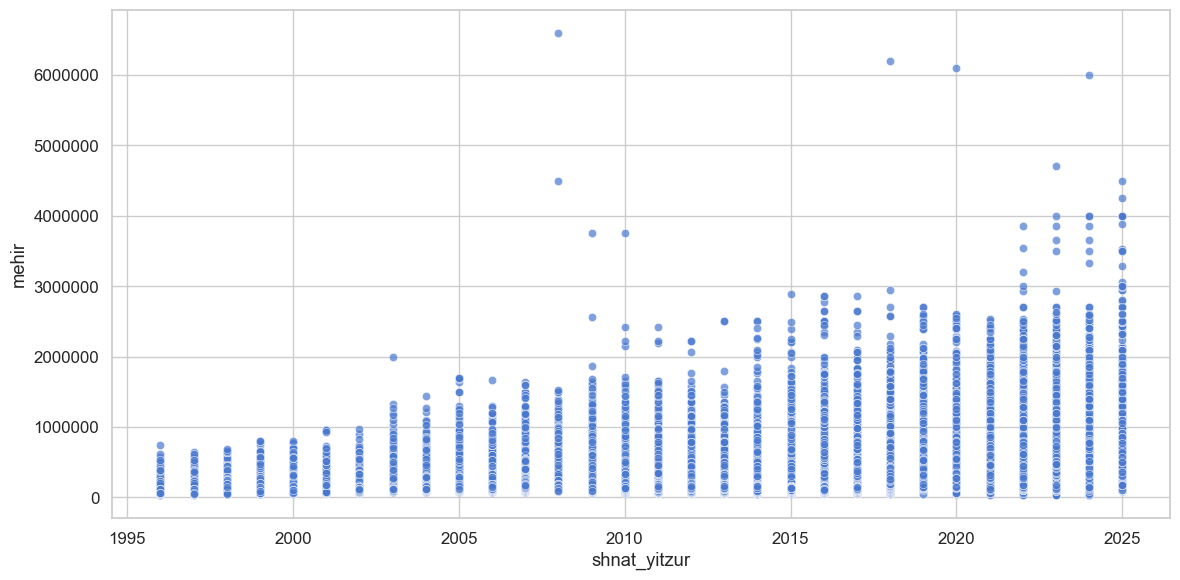

In [55]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# גרף 1 - לפי תוצרת
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=cars_prices,
    x='shnat_yitzur',
    y='mehir',
#    hue='shem_yevuan_en',
    palette='tab10',
    alpha=0.7
)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('shnat_yitzur')
plt.ylabel('mehir')
#plt.legend(title='שם תוצרת', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

According to the graph, there is a correlation between the 'shnat_yitzur' and the 'mehir'

C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


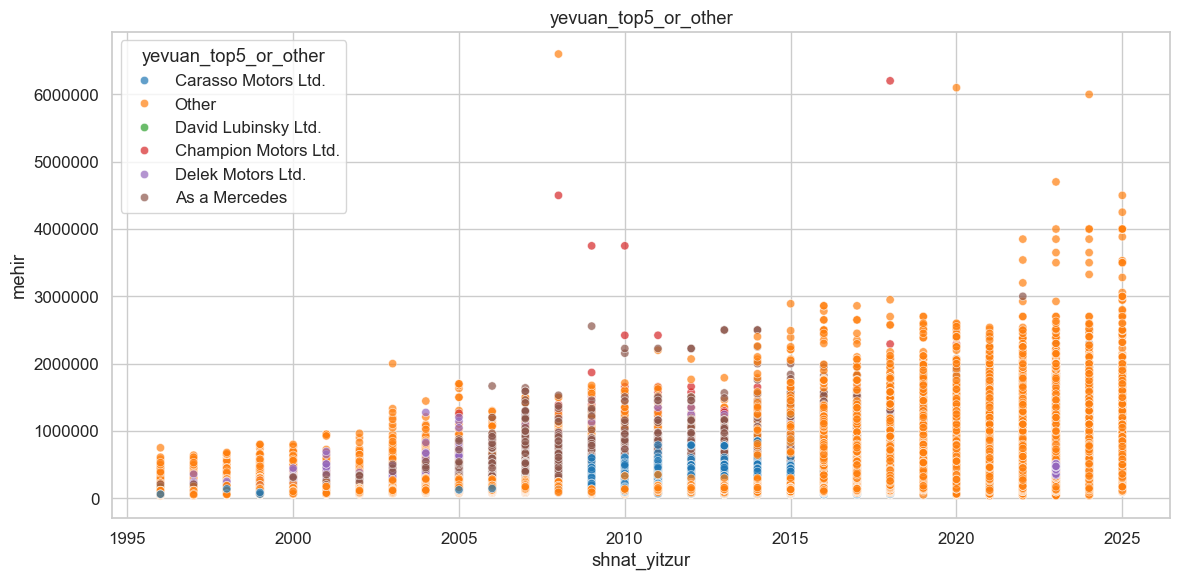

In [56]:
top_5_yevuan = cars_prices['shem_yevuan_en'].value_counts().nlargest(5).index.tolist()
cars_prices['yevuan_top5_or_other'] = cars_prices['shem_yevuan_en'].apply(
    lambda x: x if x in top_5_yevuan else 'Other'
)
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=cars_prices,
    x='shnat_yitzur',
    y='mehir',
    hue='yevuan_top5_or_other',
    palette='tab10',
    alpha=0.7
)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('shnat_yitzur')
plt.ylabel('mehir')
plt.title('yevuan_top5_or_other')
plt.legend(title='yevuan_top5_or_other')
plt.tight_layout()
plt.show()


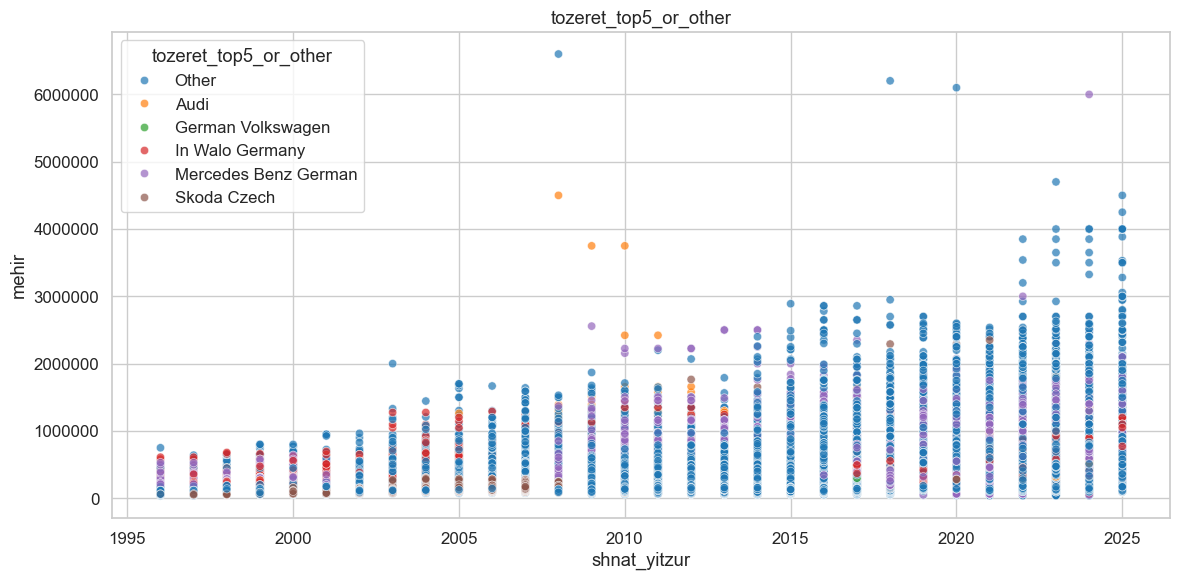

In [57]:
top_5_tozeret = cars_prices['tozeret_nm_en'].value_counts().nlargest(5).index.tolist()
cars_prices['tozeret_top5_or_other'] = cars_prices['tozeret_nm_en'].apply(
    lambda x: x if x in top_5_tozeret else 'Other'
)
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=cars_prices,
    x='shnat_yitzur',
    y='mehir',
    hue='tozeret_top5_or_other',
    palette='tab10',
    alpha=0.7
)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('shnat_yitzur')
plt.ylabel('mehir')
plt.title('tozeret_top5_or_other')
plt.legend(title='tozeret_top5_or_other')
plt.tight_layout()
plt.show()

Search for outliers

In [58]:
cars_prices[cars_prices['mehir'] > 3000000].sort_values(by='mehir')

,_id,semel_yevuan,shem_yevuan,sug_degem,tozeret_cd,tozeret_nm,degem_cd,degem_nm,shnat_yitzur,mehir,kinuy_mishari,shem_yevuan_en,tozeret_nm_en,yevuan_top5_or_other,tozeret_top5_or_other
72651,72652,242,"אורכיד ספורטס קארס בע""מ",P,983,בנטלי בריטניה,83,3S,2025,3057000,CONTINENTAL GTC,Orchid Sports Cars Ltd.,Bentley Britain,Other,Other
88055,88056,850,"ספיישל קארס בע""מ",P,869,"קרייזלר ארה""ב",536,JXAG,2022,3200000,JEEP WARANGLER,Special Cars Ltd.,US chrysler,Other,Other
42566,42567,125,"סמלת מוטורס בע""מ",P,770,פרארי,63,F167 ADA,2025,3280000,12CILINDRI SPI,Motors Symbol Ltd.,Ferrari,Other,Other
42497,42498,125,"סמלת מוטורס בע""מ",P,770,פרארי,58,F175 AHA,2024,3325000,PUROSANGUE,Motors Symbol Ltd.,Ferrari,Other,Other
90863,90864,1031,משה לגזייל,P,942,רולס-רויס,3,TV61,2024,3500000,CULLINAN,Moses to Gazil,Rolls-Royce,Other,Other
75817,75818,401,סבח מוצרי תעבורה,P,441,למבורגיני,17,EA6Z,2025,3500000,HURACAN,Transport Product Sabah,Lamborghini,Other,Other
90876,90877,1031,משה לגזייל,P,942,רולס-רויס,3,TV61,2025,3500000,CULLINAN,Moses to Gazil,Rolls-Royce,Other,Other
42375,42376,125,"סמלת מוטורס בע""מ",P,770,פרארי,58,F175 AHA,2023,3500000,PUROSANGUE,Motors Symbol Ltd.,Ferrari,Other,Other
42562,42563,125,"סמלת מוטורס בע""מ",P,770,פרארי,58,F175 AHA,2025,3530000,PUROSANGUE,Motors Symbol Ltd.,Ferrari,Other,Other
55335,55336,134,"קבוצת עמק איילון ס.כ. בע""מ",P,869,"קרייזלר ארה""ב",487,JXDN,2022,3540000,JEEP WRANGLER,Ayalon Valley Group SP Ltd.,US chrysler,Other,Other


C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


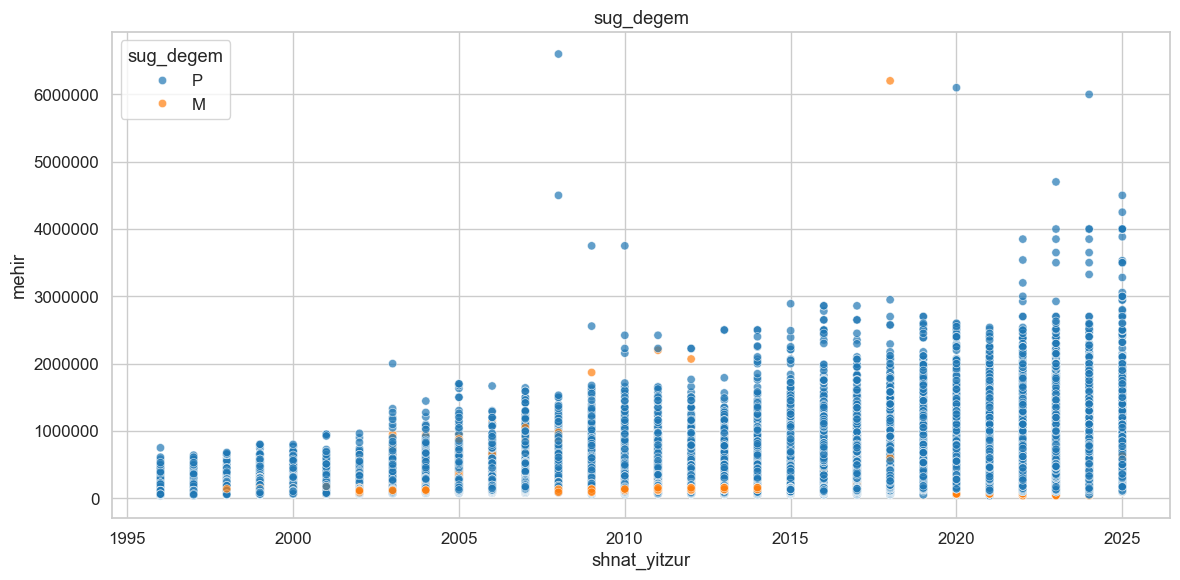

In [66]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=cars_prices,
    x='shnat_yitzur',
    y='mehir',
    hue='sug_degem',
    palette='tab10',
    alpha=0.7
)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('shnat_yitzur')
plt.ylabel('mehir')
plt.title('sug_degem')
plt.legend(title='sug_degem')
plt.tight_layout()
plt.show()

I have no further insights from the graph.

## 4.machine learning

### 4.1 RandomForest

In [60]:
df = cars_prices.copy()
label_encoders = {}

for col in df.columns:
    if df[col].dtype == 'object' or df[col].nunique() < 1000:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

X = df.drop(columns=['mehir'])
y = df['mehir']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R^2: {r2:.2f}')


MSE: 7360837560.96
R^2: 0.92


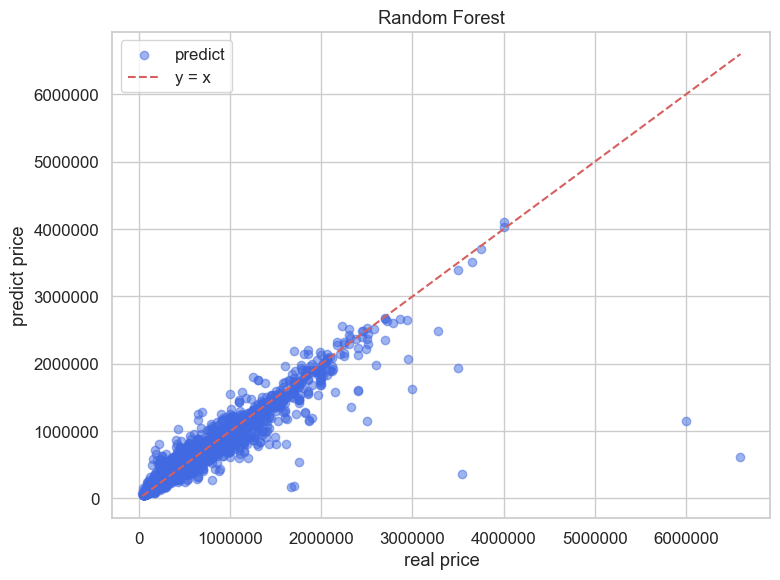

In [61]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue', label='predict')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y = x')
plt.xlabel('real price')
plt.ylabel('predict price')
plt.title('Random Forest')
plt.legend()
plt.grid(True)

#  הפיכת התצוגה למספרים רגילים
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().ticklabel_format(style='plain', axis='both')  # אופציונלי, מונע פורמט מדעי

plt.tight_layout()
plt.show()


The value came out too high — it's suspicious.

In [62]:
# קבלת חשיבות הפיצ'רים מהמודל
importances = model.feature_importances_

# יצירת DataFrame עם שמות עמודות
feat_importance_df = pd.DataFrame(
    {'feature': X.columns, 'importance': importances}
).sort_values(by='importance', ascending=False)

# הצגת 10 המובילים
print(feat_importance_df.head(10))


                 feature  importance
9          kinuy_mishari        0.17
0                    _id        0.17
11         tozeret_nm_en        0.15
7               degem_nm        0.13
4             tozeret_cd        0.08
5             tozeret_nm        0.07
6               degem_cd        0.06
2            shem_yevuan        0.05
12  yevuan_top5_or_other        0.04
8           shnat_yitzur        0.02


## 5.back to EDA

### 5.1 Correlation analysis

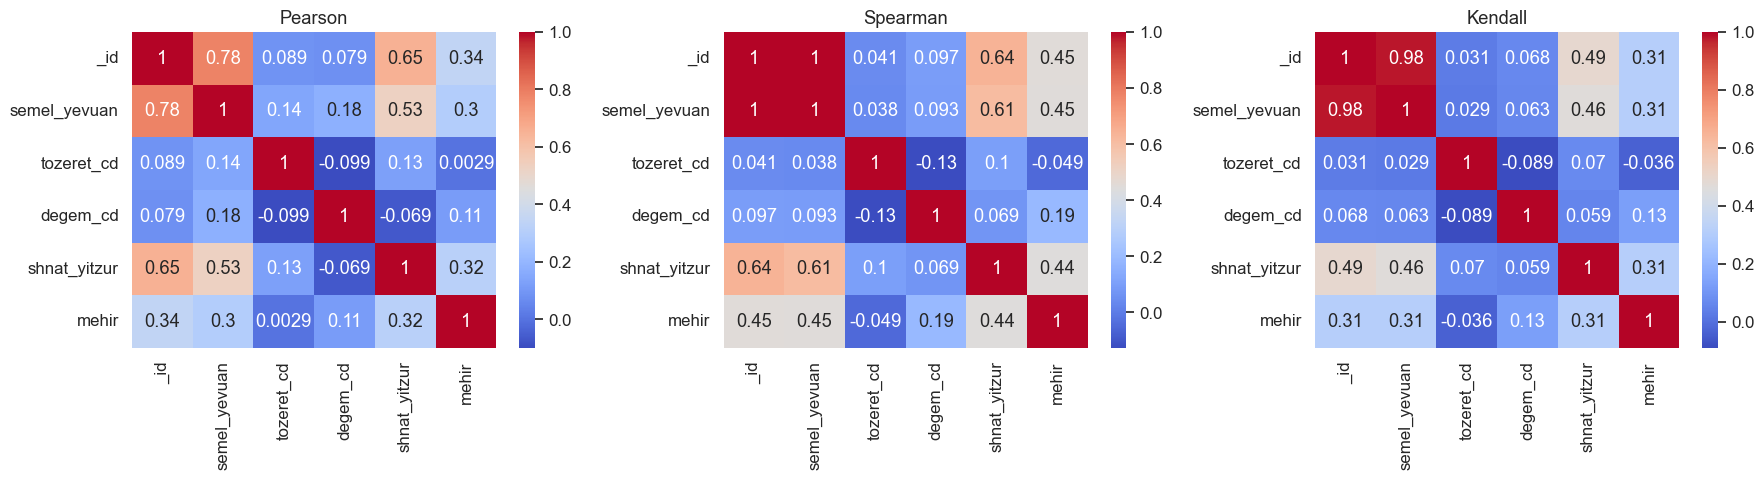

In [73]:

# סינון רק עמודות מספריות
numeric_data = cars_prices.select_dtypes(include=['number'])

# רשימת שיטות חישוב
methods = ['pearson', 'spearman', 'kendall']

# יצירת התמונה עם 3 תת-גרפים
plt.figure(figsize=(18, 5))

for i, method in enumerate(methods, 1):  # מתחילים מ-1 בשביל subplot
    corr_matrix = numeric_data.corr(method=method)
    plt.subplot(1, 3, i)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(method.capitalize())

plt.tight_layout()
plt.show()


There is a correlation between ID and Semel yevuan

C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


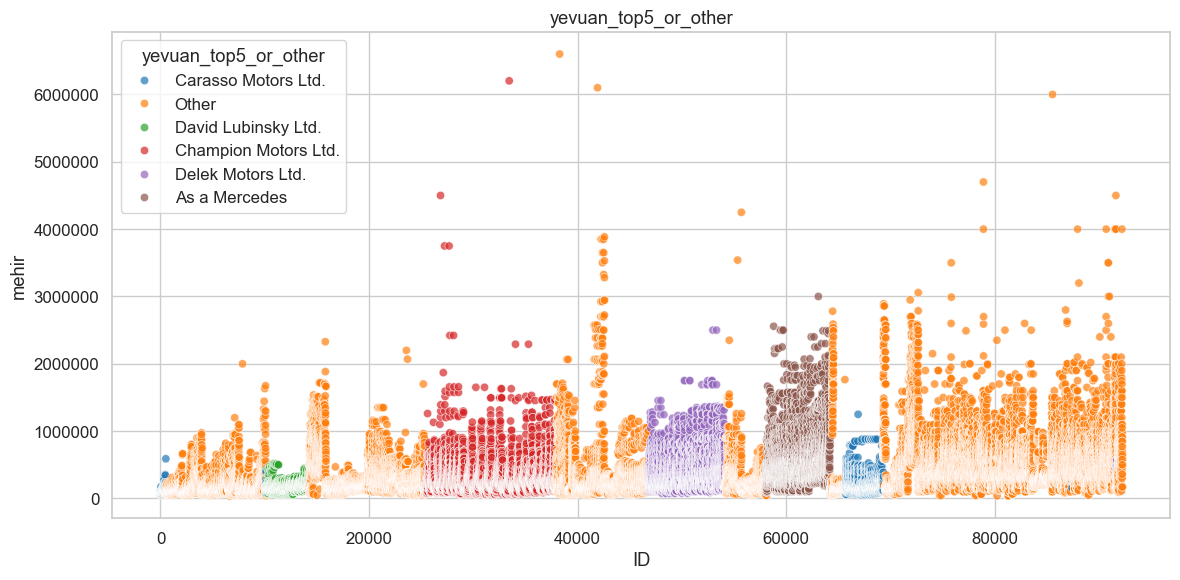

In [64]:

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=cars_prices,
    x='_id',
    y='mehir',
    hue='yevuan_top5_or_other',
    palette='tab10',
    alpha=0.7
)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('ID')
plt.ylabel('mehir')
plt.title('yevuan_top5_or_other')
plt.legend(title='yevuan_top5_or_other')
plt.tight_layout()
plt.show()

The ID correlates with price, so it should be excluded from the next model to avoid bias.

C:\Users\user\AppData\Local\Temp\ipykernel_9032\1569859295.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


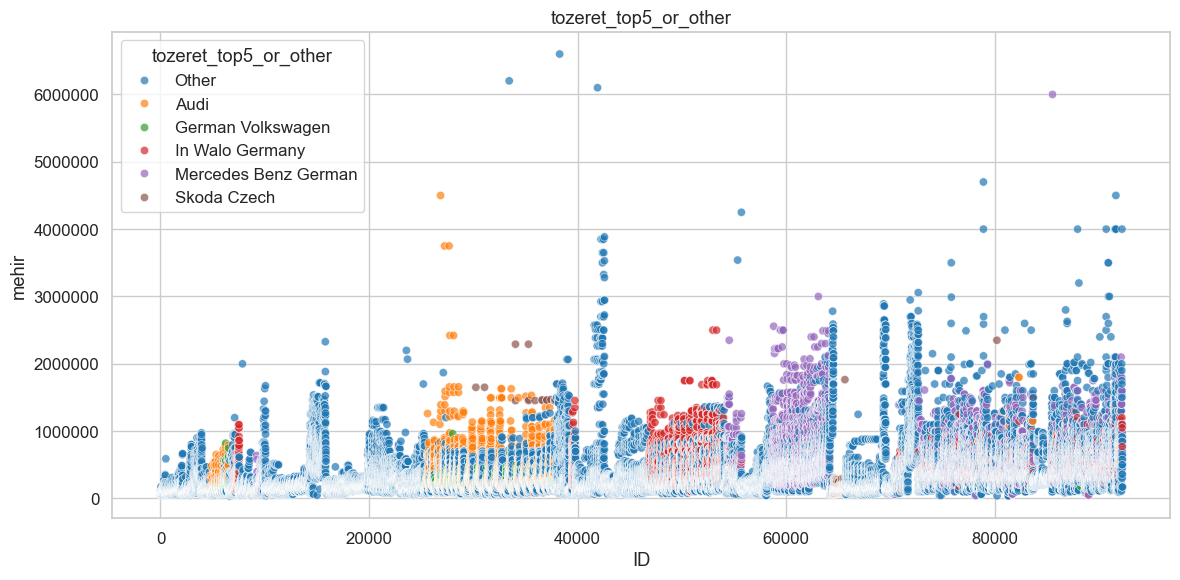

In [67]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=cars_prices,
    x='_id',
    y='mehir',
    hue='tozeret_top5_or_other',
    palette='tab10',
    alpha=0.7
)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('ID')
plt.ylabel('mehir')
plt.title('tozeret_top5_or_other')
plt.legend(title='tozeret_top5_or_other')
plt.tight_layout()
plt.show()

### 5.2 Exploring the 'kinuy_mishari' column

We found that the 'kinuy_mishari' column is the most predictive feature, so we will analyze it further.

In [68]:
df.groupby("kinuy_mishari")["mehir"].describe().sort_values("mean", ascending=False)

,count,mean,std,min,25%,50%,75%,max
kinuy_mishari,,,,,,,,
3575,1.00,4249900.00,NaN,4249900.00,4249900.00,4249900.00,4249900.00,4249900.00
1957,3.00,4000000.00,0.00,4000000.00,4000000.00,4000000.00,4000000.00,4000000.00
3565,4.00,3858750.00,17500.00,3850000.00,3850000.00,3850000.00,3858750.00,3885000.00
1420,8.00,3837500.00,504090.41,3000000.00,3500000.00,4000000.00,4000000.00,4700000.00
3643,3.00,3700000.00,984885.78,2600000.00,3300000.00,4000000.00,4250000.00,4500000.00
...,...,...,...,...,...,...,...,...
5018,2.00,42350.00,0.00,42350.00,42350.00,42350.00,42350.00,42350.00
5020,1.00,40410.00,NaN,40410.00,40410.00,40410.00,40410.00,40410.00
2655,4.00,40000.00,0.00,40000.00,40000.00,40000.00,40000.00,40000.00


In [72]:
df.groupby("kinuy_mishari")["mehir"].std().mean()

35453.31251702098

In [69]:
yevuan_counts = cars_prices['kinuy_mishari'].value_counts(dropna=False)
yevuan_percents = yevuan_counts / len(cars_prices) * 100
yevuan_df = pd.DataFrame({
    'kinuy_mishari': yevuan_counts.index,
    'count': yevuan_counts.values,
    'percent': yevuan_percents.values.round(2)
})
yevuan_df.sort_values(by='count', ascending=False, inplace=True)
print(yevuan_df.head(10))

   kinuy_mishari  count  percent
0        MODEL 3   1182     1.28
1        OCTAVIA   1108     1.20
2           GOLF    758     0.82
3   LAND CRUISER    624     0.68
4          IBIZA    617     0.67
5    TRANSPORTER    614     0.67
6             A3    544     0.59
7       BERLINGO    533     0.58
8  R ROVER SPORT    508     0.55
9          JUMPY    489     0.53


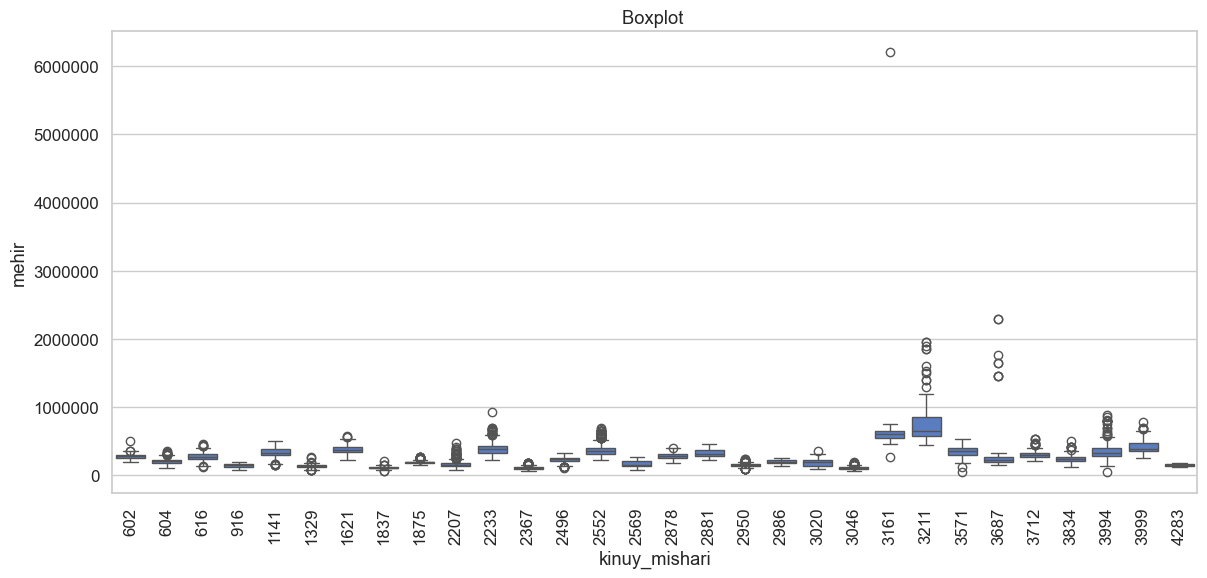

In [70]:
top_models = df["kinuy_mishari"].value_counts().head(30).index

plt.figure(figsize=(14, 6))
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(data=df[df["kinuy_mishari"].isin(top_models)],
            x="kinuy_mishari", y="mehir")
plt.xticks(rotation=90)
plt.title("Boxplot ")
plt.show()


It seems that the variance within each brand name is very low, which makes it a strong predictor

### 5.3 Unique Code per Name Check


In the upcoming models, I will avoid multicollinearity by using only codes instead of names.  
I will now check that each code has a unique corresponding name


In [74]:
mismatch_names = cars_prices.groupby('tozeret_nm')['tozeret_cd'].nunique()
mismatch_names = mismatch_names[mismatch_names > 1]
print("שמות יבואן עם יותר מקוד אחד:")
print(mismatch_names)

שמות יבואן עם יותר מקוד אחד:
tozeret_nm
אלפא רומיאו    2
דאציה סין      2
Name: tozeret_cd, dtype: int64


In [75]:
mismatch_names = cars_prices.groupby('shem_yevuan')['semel_yevuan'].nunique()
mismatch_names = mismatch_names[mismatch_names > 1]
print("שמות יבואן עם יותר מקוד אחד:")
print(mismatch_names)

שמות יבואן עם יותר מקוד אחד:
shem_yevuan
א. ברזני הסעות בע"מ               2
א.א.מ עמנואל השקעות בע"מ          2
א.נ.ר.נ. חברה למסחר בע"מ          2
אוטו חן בע"מ                      3
אוטו פרימיום סי.אר.אס בע"מ        2
אוטוארט)אי.אל(בע"מ                2
איגואנה קלאב )הכרמל( בע"מ         2
אילן בן דוד יבואן רכב בע"מ        2
אנוקוב גרופ בע"מ                  2
אפ 1 פתרונות פיננסים בע"מ         2
ב.ה. אופיר ליסינג בע"מ            2
בלאק פוקס ישראל בע"מ              2
ג.ל.ח יבוא אוטו בע"מ              2
גז פרו בע"מ                       2
גיא מאור בע"מ                     2
גיאו מוביליטי בע"מ                2
דלק מוטורס בע"מ                   2
הדר קאר אימפורט בע"מ              2
המאגר ב.נ.כ. בע"מ                 2
חברת המזרח                        2
חן מוטורס בע"מ                    3
טל - קאר                          2
טסלה מוטורס ישראל בע"מ            2
יארין ג ב אחזקות בע"מ             2
ידידיה תעשיות ונכסים בע"מ         2
יעד ליסינג ומימון לרכב בע"מ       2
כלמוביל בע"מ           

In [76]:
cars_prices[cars_prices['shem_yevuan'] == 'רוני מוטורס סוכנות רכב בע"מ']

,_id,semel_yevuan,shem_yevuan,sug_degem,tozeret_cd,tozeret_nm,degem_cd,degem_nm,shnat_yitzur,mehir,kinuy_mishari,shem_yevuan_en,tozeret_nm_en,yevuan_top5_or_other,tozeret_top5_or_other
75639,75640,400,"רוני מוטורס סוכנות רכב בע""מ",P,143,ב מ וו גרמניה,932,JA91,2019,480000,530E I PER,Ronnie Motors Car Agency Ltd.,In Walo Germany,Other,In Walo Germany
75640,75641,400,"רוני מוטורס סוכנות רכב בע""מ",P,143,ב מ וו גרמניה,967,JA91,2019,420000,530E I PER,Ronnie Motors Car Agency Ltd.,In Walo Germany,Other,In Walo Germany
75641,75642,400,"רוני מוטורס סוכנות רכב בע""מ",P,593,מרצדס בנץ גרמנ,1088,213.050,2019,430000,E 350E,Ronnie Motors Car Agency Ltd.,Mercedes Benz German,Other,Mercedes Benz German
75642,75643,400,"רוני מוטורס סוכנות רכב בע""מ",P,593,מרצדס בנץ גרמנ,1312,213.042,2019,430000,E200,Ronnie Motors Car Agency Ltd.,Mercedes Benz German,Other,Mercedes Benz German
75643,75644,400,"רוני מוטורס סוכנות רכב בע""מ",P,593,מרצדס בנץ גרמנ,1352,213.053,2019,370000,E300 E,Ronnie Motors Car Agency Ltd.,Mercedes Benz German,Other,Mercedes Benz German
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83484,83485,687,"רוני מוטורס סוכנות רכב בע""מ",P,1207,מרצדס בנץ ד.אפ,47,AF5E,2025,550000,C300 E,Ronnie Motors Car Agency Ltd.,Mercedes Benz DP,Other,Other
83485,83486,687,"רוני מוטורס סוכנות רכב בע""מ",P,1245,לנדרובר אנגליה,126,1L9FU,2025,949900,R ROVER SPORT,Ronnie Motors Car Agency Ltd.,Landrover England,Other,Other
83486,83487,687,"רוני מוטורס סוכנות רכב בע""מ",P,1245,לנדרובר אנגליה,137,1A2B4,2025,969900,R ROVER SPORT,Ronnie Motors Car Agency Ltd.,Landrover England,Other,Other
83487,83488,687,"רוני מוטורס סוכנות רכב בע""מ",P,1245,לנדרובר אנגליה,138,1A2BW,2025,870000,R ROVER SPORT,Ronnie Motors Car Agency Ltd.,Landrover England,Other,Other


## 6.back to ML

### 6.1 Random Forest

In [105]:
df = cars_prices.copy() 
label_encoders = {}

for col in df.columns:
    if df[col].dtype == 'object' or df[col].nunique() < 1000:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

X = df.drop(columns=['mehir','tozeret_top5_or_other','yevuan_top5_or_other','tozeret_nm_en','shem_yevuan_en','degem_nm'
                    ,'tozeret_nm','shem_yevuan','_id'])
y = df['mehir']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R^2: {r2:.2f}')


MSE: 8504320524.64
R^2: 0.91


### 6.2 Hyperparameters of Random Forest

We try 50 100 200 and 300 of estimators  
We already tried 100; let's check the others

### 50

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R^2: {r2:.2f}')


MSE: 8464916967.87
R^2: 0.91


### 200

In [80]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R^2: {r2:.2f}')


MSE: 8442619080.26
R^2: 0.91


### 300

In [79]:

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R^2: {r2:.2f}')


MSE: 8454397132.07
R^2: 0.91


Conclusion stay with 50

In [107]:
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R^2: {r2:.2f}')

MSE: 8464916967.87
R^2: 0.91


In [109]:
### 6.3 feature_importances of Random Forest

Which features influence the model the most

In [108]:
importances = model.feature_importances_
feat_importance_df = pd.DataFrame(
    {'feature': X.columns, 'importance': importances}
).sort_values(by='importance', ascending=False)
print(feat_importance_df.head(10))


         feature  importance
5  kinuy_mishari        0.35
2     tozeret_cd        0.22
0   semel_yevuan        0.16
3       degem_cd        0.14
4   shnat_yitzur        0.12
1      sug_degem        0.00


The most influential feature is a 'kinuy_mishari', which means it will be difficult to know the prices of the new models

### 6.4 XGBoost

In [ ]:
model = XGBRegressor(n_estimators=100,max_depth=3,learning_rate=0.1,subsample=0.8, colsample_bytree=0.8,random_state=42,objective='reg:squarederror',n_jobs=-1)

In [110]:
model = XGBRegressor(n_estimators=100,max_depth=3,learning_rate=0.1,subsample=0.8, colsample_bytree=0.8,random_state=42,objective='reg:squarederror',n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R^2: {r2:.2f}')


MSE: 42322999729.97
R^2: 0.54


It seems that the XGBoost model performs worse than Random Forest, so we'll proceed to hyperparameter tuning

In [ ]:
### 6.5 Hyperparameters of Random Forest

In [111]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
import pandas as pd


xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# טווח פרמטרים לבדיקה
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# הגדרת Grid Search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',         # ניתן לשנות ל-'neg_mean_absolute_error' וכו'
    cv=3,                 # קרוס ולידציה עם 3 קיפולים
    verbose=1,
    n_jobs=-1             # להריץ במקביל על כל הליבות
)

# הפעלת Grid Search
grid_search.fit(X_train, y_train)

# תוצאות
print("Best parameters found:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best R2 score: 0.8656544089317322


This is the result:  
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}  
Best R2 score: 0.8656544089317322

Surprisingly, Random Forest performed better than XGBoost; therefore,  
I will retain the Random Forest model, as it produced better results

Random Forest depends on the 'Brand Name', so it struggles to predict new models

Recommendation for the next work: add features and improve the model to reduce dependence on the 'Brand Name' column